In [1]:
# Core
import os
import glob
import math
from pathlib import Path
import re

# Data handling
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point, box, shape, LineString
import shapely.ops as ops

# Statistics and modeling
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

# Mapping / geospatial
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import rioxarray
from rasterio.features import geometry_mask
from pyproj import Transformer

# Colormaps
import cmocean
from cmocean import tools
import cmasher as cmr

# Windrose
from windrose import WindroseAxes
import yaml


In [2]:
# Configuration and project paths
NOTEBOOK_DIR = Path.cwd().resolve()
config_candidates = [NOTEBOOK_DIR / 'config.yml', NOTEBOOK_DIR.parent / 'config.yml']
for cand in config_candidates:
    if cand.exists():
        CONFIG_PATH = cand
        break
else:
    raise FileNotFoundError('config.yml not found in the current or parent directory')

import yaml as _yaml
with open(CONFIG_PATH, 'r') as f:
    config = _yaml.safe_load(f) or {}

PROJECT_ROOT = CONFIG_PATH.parent
DATA_DIR = (PROJECT_ROOT / config.get('data_dir', 'data')).expanduser().resolve()
FIGURES_DIR = (PROJECT_ROOT / config.get('figures_dir', 'data/figures')).expanduser().resolve()

if not DATA_DIR.exists():
    raise FileNotFoundError(f"DATA_DIR not found: {DATA_DIR}")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

SENTINEL_DIR = DATA_DIR / 'sentinel_data'
SHAPEFILE_DIR = DATA_DIR / 'lake_erie_shapefiles'
SEDIMENT_DIR = DATA_DIR / 'sediment_data'
WATER_DIR = DATA_DIR / 'water_data'
WIND_DIR = DATA_DIR / 'THOR1_WIND_DATA'
GSHHS_DIR = DATA_DIR / 'GSHHS'


## Figure 1a: May 18th SPM distribution

In [3]:
## read in polymer_l2 daily file for May 26th
poly_dly = SENTINEL_DIR / 'S3_20230526_DLY.nc'
poly_dly = xr.open_dataset(poly_dly)

## read in polymer_l2 daily file for May 18th
poly_dly_may18 = SENTINEL_DIR / 'S3_20230518_DLY.nc'
poly_dly_may18 = xr.open_dataset(poly_dly_may18)

##read shapefiles for Lake Erie
path_lake_erie_contour = SHAPEFILE_DIR / 'Lake_Erie_Contours.shp'
path_maumee            = SHAPEFILE_DIR / 'w084n41n.shp'
path_coastlines        = SHAPEFILE_DIR / 'hydro_p_LakeErie.shp'
path_med_res           = SHAPEFILE_DIR / 'us_medium_shoreline.shp'

## read stations coordinates 
# sampling sites
stations = pd.read_csv(DATA_DIR / '2016_2022_2023_2024_coordinates.csv')


In [4]:
## Medium resolution of coast boundaries
med = gpd.read_file(path_med_res )
coastlines    = gpd.read_file(path_coastlines)
# # Reproject to WGS84 if needed
# for gdf in [med, coastlines]:
#     if gdf.crs is None:
#         gdf.set_crs("EPSG:4326", inplace=True)
#     elif gdf.crs.to_string() != "EPSG:4326":
#         gdf.to_crs(epsg=4326, inplace=True)

In [5]:
## apply Nechad algorithm for May 18th
SPM_may18 = (355.85*np.pi*poly_dly_may18.Rrs_665) / (1 - ((poly_dly_may18.Rrs_665*np.pi) / 0.1728))

## make sure the SPM data has a crs for May 18th
SPM_may18 = SPM_may18.rio.write_crs('EPSG:4326')

## create mask to get rid of data over land
lake_gdf = gpd.read_file(GSHHS_DIR / 'GSHHS_f_L2.shp')

## subset by using lat/lon coords 
bounding_coords = box(-83.5, 41, -78.85, 44) #minx, miny, maxx, maxy
gl = lake_gdf[lake_gdf.intersects(bounding_coords)]

## Rasterize the lake erie mask to match data grid
lake_mask = geometry_mask(
    [gl.unary_union],  # Merge all polygons into one
    transform=SPM_may18.rio.transform(),
    invert=True,
    out_shape=(SPM_may18.sizes['lat'], SPM_may18.sizes['lon'])
)

# apply the mask for May 18th
masked_SPM_may18 = SPM_may18.where(lake_mask)
good_SPM_may18_1 = masked_SPM_may18.where(masked_SPM_may18 > 0, np.nan)


/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3101261883.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  [gl.unary_union],  # Merge all polygons into one


In [6]:
fig_dir = str(FIGURES_DIR)

# Create directory if it doesn't exist
os.makedirs(fig_dir, exist_ok=True)


/Users/anmol/Workspace/wle_p_analysis/.venv/lib/python3.9/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read(
/Users/anmol/Workspace/wle_p_analysis/.venv/lib/python3.9/site-packages/geopandas/geodataframe.py:223: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


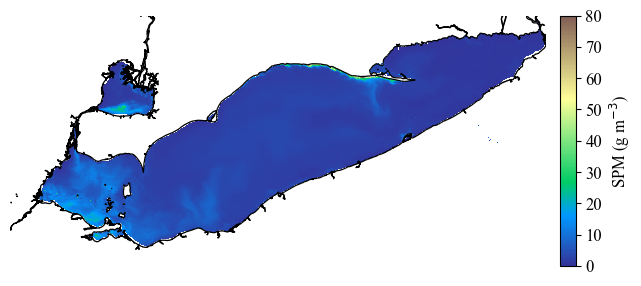

In [7]:
# --- Clip to just the Maumee River mouth area ---
plt.rcParams['font.family'] = 'Times New Roman'

maumee = gpd.read_file(path_maumee)
if maumee.crs is None:
    maumee = maumee.set_crs(4326)
else:
    maumee = maumee.to_crs(4326)

# Define tight bounding box around western Lake Erie near Toledo
WEST, EAST, SOUTH, NORTH = -84.2, -83.5, 41.5, 41.8
bbox = gpd.GeoDataFrame(geometry=[box(WEST, SOUTH, EAST, NORTH)], crs=4326)
maumee_clip = gpd.clip(maumee, bbox)

# Convert polygons to outlines so no filled areas appear
if any(maumee_clip.geom_type.isin(["Polygon", "MultiPolygon"])):
    maumee_clip = maumee_clip.boundary

# --- Figure setup ---
fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_aspect(1.3)
ax.set_extent([-83.72, -78.85, 41.25, 43], crs=ccrs.PlateCarree())

# --- Plot SPM ---
cmap = cmr.get_sub_cmap('terrain', 0, 0.75)
im = ax.pcolormesh(
    good_SPM_may18_1.lon, good_SPM_may18_1.lat, masked_SPM_may18,
    cmap=cmap, vmin=0, vmax=80,
    transform=ccrs.PlateCarree()
)

# --- Mask NaN / 0 as white ---
arr = good_SPM_may18_1.values
nodata_mask = np.where((np.isnan(arr)) | (arr == 0), 1.0, np.nan)
white_cmap = ListedColormap([(1.0, 1.0, 1.0, 1.0)])
ax.pcolormesh(
    good_SPM_may18_1.lon, good_SPM_may18_1.lat, nodata_mask,
    cmap=white_cmap, vmin=0, vmax=1,
    transform=ccrs.PlateCarree(), zorder=im.zorder+0.1
)

# --- Coastline overlay ---
ax.add_geometries(
    med.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black",
    linewidth=0.9, zorder=6
)

# --- Plot Maumee River (clipped) ---
ax.add_geometries(
    maumee_clip,
    crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black",
    linewidth=0.8, zorder=15
)

# --- Colorbar ---
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size' : 14}

cax = ax.inset_axes([1.025, 0, 0.03, 1]) 
cbar = fig.colorbar(im, cax=cax, ticks=np.arange(0, 81, 10))  # ticks every 10
cbar.set_label('SPM (g m$^{-3}$)', fontsize=12)
cbar.ax.tick_params(labelsize=12)

ax.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "F_Nechad_SPM_May-2-2023_med_res.png"), dpi=300, bbox_inches='tight')
plt.show()

## Figure 1a inset: Sampling station map

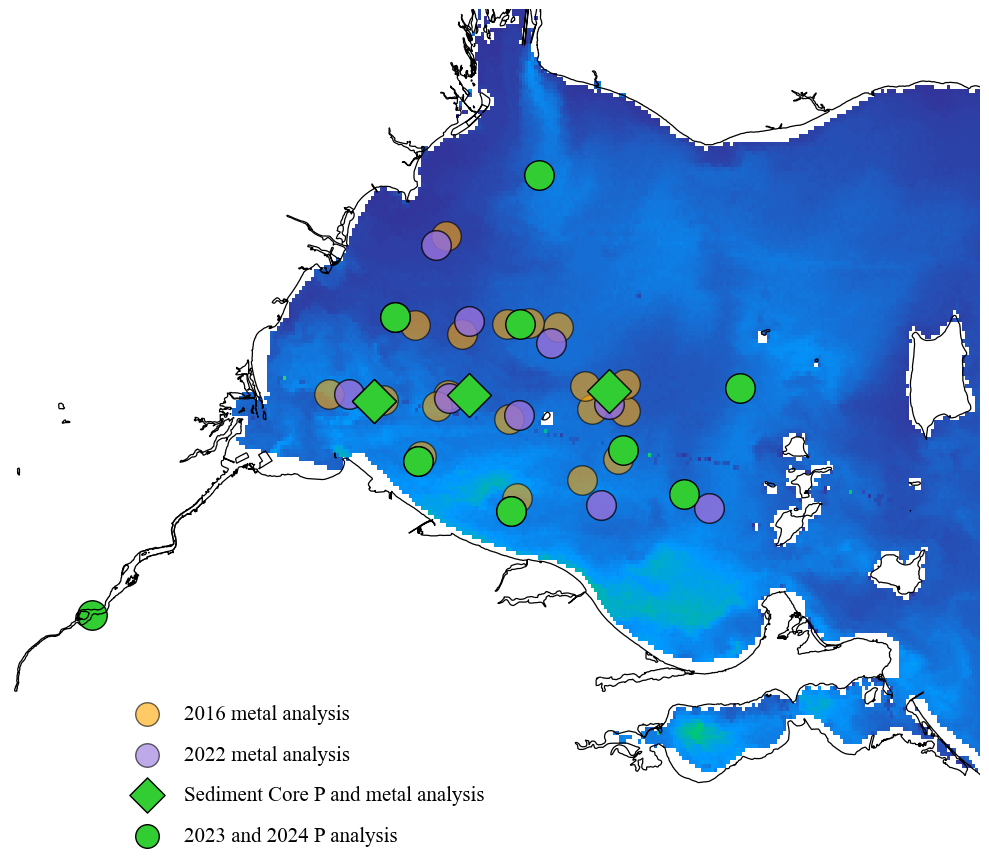

In [8]:
# --- Figure setup ---
fig = plt.figure(figsize=(10, 11))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor("white")
ax.set_aspect(1.3)
ax.set_extent([-83.72, -82.8 + 0.19, 41.4, 42.1], crs=ccrs.PlateCarree())  # zoomed

# --- Plot SPM raster ---
cmap = cmr.get_sub_cmap("terrain", 0, 0.75)
im = ax.pcolormesh(
    good_SPM_may18_1.lon, good_SPM_may18_1.lat, good_SPM_may18_1,
    cmap=cmap, vmin=0, vmax=80, transform=ccrs.PlateCarree(), zorder=0
)

# --- Plot year by year (customize freely) ---
# 2016
df16 = stations[stations["Year"] == 2016]
ax.scatter(df16["Lon"], df16["Lat"],
           marker="o", s=450, edgecolor="k",
           c="orange", alpha=0.6,
           transform=ccrs.PlateCarree(), label="2016 metal analysis")

# 2022
df22 = stations[stations["Year"] == 2022]
ax.scatter(df22["Lon"], df22["Lat"],
           marker="o", s=450, edgecolor="k",
           c="mediumpurple", alpha=0.6,
           transform=ccrs.PlateCarree(), label="2022 metal analysis")

# 2023 (Core vs Non-core)
df23_core = stations[(stations["Year"] == 2023) & (stations["Core"] == 1)]
df23_non = stations[(stations["Year"] == 2023) & (stations["Core"].isna())]


ax.scatter(df23_core["Lon"], df23_core["Lat"],
           marker="D", s=500, edgecolor="k",
           c="limegreen", alpha=1,
           transform=ccrs.PlateCarree(), label="Sediment Core P and metal analysis")

ax.scatter(df23_non["Lon"], df23_non["Lat"],
           marker="o", s=450, edgecolor="k",
           c="limegreen", alpha=1,
           transform=ccrs.PlateCarree(), label="2023 and 2024 P analysis")

# --- Overlay mask for NaN or zero values (white fill) ---
arr = good_SPM_may18_1.values
nodata_mask = np.where((np.isnan(arr)) | (arr == 0), 1.0, np.nan)
white_cmap = ListedColormap([(1, 1, 1, 1)])
ax.pcolormesh(
    good_SPM_may18_1.lon, good_SPM_may18_1.lat, nodata_mask,
    cmap=white_cmap, vmin=0, vmax=1,
    transform=ccrs.PlateCarree(), zorder=im.zorder + 0.1
)

# --- Plot Maumee (clipped, outline only) ---
ax.add_geometries(
    maumee_clip,
    crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black",
    linewidth=0.9, zorder=15
)

# --- Coastline overlay ---
ax.add_geometries(
    med.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black",
    linewidth=0.9, zorder=6
)
# --- Legend ---
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.legend(
    by_label.values(), by_label.keys(),
    loc="upper left",                # anchor corner
    bbox_to_anchor=(0.1, 0.15), 
    fontsize=15, frameon=False,
    markerscale=0.8,
    labelspacing=1   # increase vertical spacing between legend entries
) 
# ax.set_title("May 18$^{th}$", fontsize=22, x=0.5, y=0.9)
# # --- Colorbar ---
# cax = ax.inset_axes([1.025, 0, 0.03, 1])
# cbar = fig.colorbar(im, cax=cax, ticks=np.arange(0, 81, 10))  # ticks every 10
# cbar.set_label("SPM (g m$^{-3}$)", fontsize=22)
# cbar.ax.tick_params(labelsize=18)

ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "F_Nechad_SPM_May18_zoomed.png"), dpi=300, bbox_inches='tight')
plt.show()

## Figure 1b: May 26th SPM distribution

In [9]:
## apply SPM algorithm (by Nechad et al. (2010) to May 26th POLYMER file 
SPM = (355.85*np.pi*poly_dly.Rrs_665) / (1 - ((poly_dly.Rrs_665*np.pi) / 0.1728))

## make sure the SPM data has a crs
SPM = SPM.rio.write_crs("EPSG:4326")

# apply the mask
masked_SPM = SPM.where(lake_mask)
good_masked_spm_26 = masked_SPM.where(masked_SPM > 0, np.nan)

In [10]:
savepath = SENTINEL_DIR
masked_SPM.to_netcdf(savepath / 'Nechad_SPM_May-26-2023.nc', 'w')


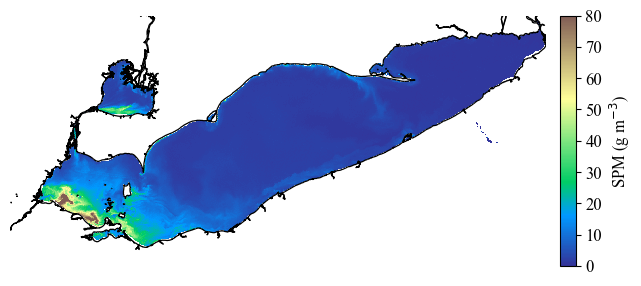

In [11]:
# Convert polygons to outlines so no filled areas appear
if any(maumee_clip.geom_type.isin(["Polygon", "MultiPolygon"])):
    maumee_clip = maumee_clip.boundary

# --- Figure setup ---
fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_aspect(1.3)
ax.set_extent([-83.72, -78.85, 41.25, 43], crs=ccrs.PlateCarree())

# --- Plot SPM ---
cmap = cmr.get_sub_cmap('terrain', 0, 0.75)
im = ax.pcolormesh(
    good_masked_spm_26.lon, good_masked_spm_26.lat, good_masked_spm_26,
    cmap=cmap, vmin=0, vmax=80,
    transform=ccrs.PlateCarree()
)

# --- Mask NaN / 0 as white ---
arr = good_masked_spm_26.values
nodata_mask = np.where((np.isnan(arr)) | (arr == 0), 1.0, np.nan)
white_cmap = ListedColormap([(1.0, 1.0, 1.0, 1.0)])
ax.pcolormesh(
    good_masked_spm_26.lon, good_masked_spm_26.lat, nodata_mask,
    cmap=white_cmap, vmin=0, vmax=1,
    transform=ccrs.PlateCarree(), zorder=im.zorder+0.1
)

# --- Coastline overlay ---
ax.add_geometries(
    med.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black",
    linewidth=0.9, zorder=6
)

# --- Plot Maumee River (clipped) ---
ax.add_geometries(
    maumee_clip,
    crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black",
    linewidth=0.8, zorder=15
)

# --- Colorbar ---
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size' : 12}

cax = ax.inset_axes([1.025, 0, 0.03, 1]) 
cbar = fig.colorbar(im, cax=cax, ticks=np.arange(0, 81, 10))  # ticks every 10
cbar.set_label('SPM (g m$^{-3}$)', fontsize=12)
cbar.ax.tick_params(labelsize=12)

ax.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "F_Nechad_SPM_May-26-2023_med_res"), dpi=300, bbox_inches='tight')
plt.show()

## Subtract May 18th from May 26th to get change in SPM

In [12]:
SPM_diff_good = good_masked_spm_26 - good_SPM_may18_1

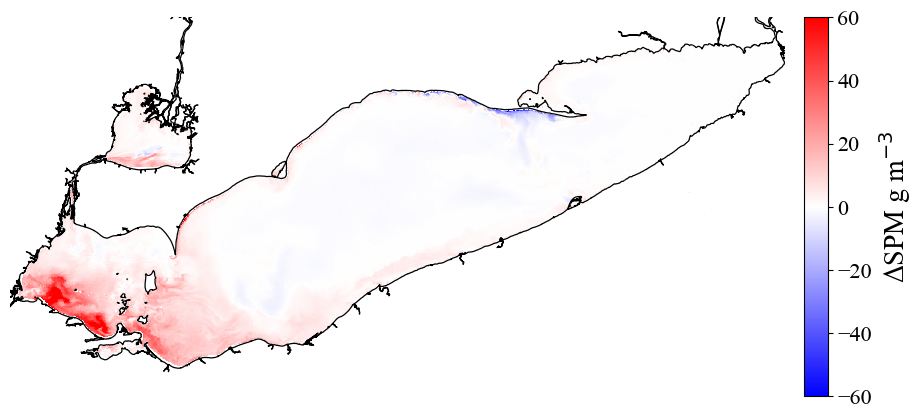

In [13]:

## plot the masked SPM data
fig = plt.figure(figsize=(10, 11))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor('white')  
ax.set_aspect(1.3)
ax.set_extent([-78.85, -83.5, 41.25, 43], crs=ccrs.PlateCarree())

im = ax.pcolormesh(SPM_diff_good.lon, SPM_diff_good.lat, SPM_diff_good, cmap = 'bwr', vmin = -60, vmax = 60, transform=ccrs.PlateCarree())

#  Add gridlines with labels
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linestyle='--', color='gray', alpha=0.5)
# gl.right_labels = False   # no labels on right
# gl.top_labels = False     # no labels on top
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER

# --- Add to map ---
ax.add_geometries(
    med.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black", linewidth=0.9, zorder=6,
    label="Defined Coast (N40W085)"
)

# ax.add_geometries(
#     coastlines.geometry,
#     crs=ccrs.PlateCarree(),
#     facecolor="none", edgecolor="black", linewidth=1, zorder=7,
#     label="Hydro Lake Erie"
# )

# ax.axis('off')
ax.axis('off')
cax = ax.inset_axes([1.025, 0, 0.03, 1]) # Draw the colorbar
cbar=fig.colorbar(im, cax=cax)
cbar.set_label("ΔSPM g m$^{-3}$", fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.savefig(os.path.join(fig_dir, "Nechad_SPM_Difference_May26-May18_med_res"), dpi=300, bbox_inches='tight')
plt.show()

## Region where SPM >= 13.9% difference (NRMSE for SPM algorithm)

In [14]:
SPM_diff_perc = (SPM_diff_good / np.abs(good_SPM_may18_1)) * 100

In [15]:
##SPM_subset from only positive and 13.9% NRMSE
SPM_subset = SPM_diff_good.where(np.isnan(masked_SPM) | ((SPM_diff_perc >= 13.9) & (SPM_diff_good.lat <= 43)), -999)

SPM_subset_masked = SPM_subset.where(SPM_subset != -999)
fill_data = SPM_subset.where(SPM_subset == -999)

## ## Figure 1c: Change in SPM in Lake Erie after resuspension


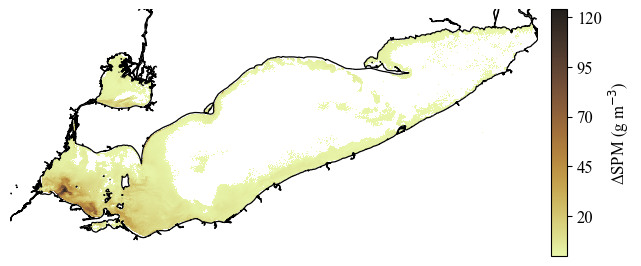

In [16]:
## plotting change in SPM with 13.9% NRMSE

fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_aspect(1.3)


ax.set_extent([-83.72, -78.85, 41.25, 43], crs=ccrs.PlateCarree())
im = ax.pcolormesh(SPM_subset_masked.lon, SPM_subset_masked.lat, SPM_subset_masked, cmap = cmocean.cm.turbid, vmin = SPM_subset_masked.min(), vmax=SPM_subset_masked.max().values, transform=ccrs.PlateCarree())


# --- Add to map ---
ax.add_geometries(
    med.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black", linewidth=0.9, zorder=6,
    label="Defined Coast (N40W085)"
)

ax.add_geometries(
    maumee_clip,
    crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black",
    linewidth=0.9, zorder=15
)


cax = ax.inset_axes([1.025, 0, 0.03, 1]) # Draw the colorbar
cbar=fig.colorbar(im, cax=cax, ticks=np.arange(20, 175, 25))
cbar.set_label("ΔSPM (g m$^{-3}$)", fontsize=12)
cbar.ax.tick_params(labelsize=12)
ax.axis('off')

plt.tight_layout()

plt.savefig(os.path.join(fig_dir, "F_Nechad_SPM_Difference_Thresholded_May26-May18_med_res.png"), dpi=300, bbox_inches='tight')

In [17]:
PIXEL_SIDE_M  = 300.0
PIXEL_AREA_M2 = PIXEL_SIDE_M ** 2   
D_eff_m       = 1.0                   

LE_box = ((SPM_subset_masked.lon >= -83.72) & (SPM_subset_masked.lon <= -78.85) &
          (SPM_subset_masked.lat >= 41.25) & (SPM_subset_masked.lat <= 42.1))

SPM_resusp = SPM_subset_masked
SPM_resusp_LE = SPM_resusp.where(LE_box)

# Convert to total grams
SPM_total_g = float((SPM_resusp_LE * PIXEL_AREA_M2 * D_eff_m).sum(skipna=True))

# Convert to metric tons
SPM_total_t = SPM_total_g / 1e3

print(f"Total resuspended sediment: {SPM_total_t:,.2f} Kg")


Total resuspended sediment: 49,436,848.13 Kg


In [18]:
wb_box = ((SPM_subset_masked.lon >= -83.5) & (SPM_subset_masked.lon <= -82.0) &
          (SPM_subset_masked.lat >= 41.25) & (SPM_subset_masked.lat <= 42.1))

SPM_resusp = SPM_subset_masked

# Apply bounding box
SPM_resusp_WB = SPM_resusp.where(wb_box)


total_sed_g_WB = float((SPM_resusp_WB * PIXEL_AREA_M2 * D_eff_m).sum(skipna=True))
total_sed_t_WB = total_sed_g_WB / 1e3  # grams → metric tons
# 
print(f"Total resuspended sediment (Western Basin): {total_sed_t_WB:,.2f} kg")


Total resuspended sediment (Western Basin): 45,178,331.14 kg


In [19]:
percentage_wle = (total_sed_t_WB /SPM_total_t)*100
print(percentage_wle)

91.38594559876874


## Figure 5: Phosphorus estimates from satellite-derived change in SPM 

In [20]:
lake_erie_contour = gpd.read_file(path_lake_erie_contour)

In [21]:
# Use SPM_diff as the reference grid (required)
if "SPM_subset_masked" not in globals():
    raise NameError("SPM_diff not found. Make sure SPM difference DataArray is defined.")

ref = SPM_subset_masked
if not isinstance(ref, xr.DataArray):
    raise TypeError("SPM_diff must be an xarray.DataArray with lat/lon coords.")

def _find_dim(da, candidates):
    for c in candidates:
        if c in da.dims: return c
    for d in da.dims:
        for c in candidates:
            if c in d: return d
    raise ValueError(f"Could not find dims among {candidates} in {da.dims}")

lat_name = _find_dim(ref, ['lat','latitude','y'])
lon_name = _find_dim(ref, ['lon','longitude','x'])

# 1) Get bathymetry contours (vector) from existing variable/path
try:
    gdf = lake_erie_contour
except NameError:
    raise NameError("`lake_bathymetry` (GeoDataFrame or path to contours) not found.")

if not isinstance(gdf, gpd.GeoDataFrame):
    gdf = gpd.read_file(gdf)

# Choose depth column; make positive meters (auto-handle sign)
depth_col = None
for c in ('DEPTH','depth','ZVALUE','Z'):
    if c in gdf.columns: depth_col = c; break
if depth_col is None:
    raise ValueError("No depth column found in lake_bathymetry (looked for 'DEPTH','depth','ZVALUE','Z').")

vals_raw = gdf[depth_col].astype(float).values
gdf = gdf.copy()
gdf['depth_m'] = -vals_raw if np.nanmedian(vals_raw) < 0 else vals_raw
gdf['depth_m'] = np.abs(gdf['depth_m'])  # ensure positive

# 2) Reproject contours & target grid to a metric CRS (UTM 17N)
gdf = gdf.to_crs(32617)

lon_vals = ref[lon_name].values
lat_vals = ref[lat_name].values
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)
to_utm = Transformer.from_crs(4326, 32617, always_xy=True)
Xutm, Yutm = to_utm.transform(lon2d, lat2d)

# 3) Densify lines into sample points (~200 m spacing for ~300 m pixels)
def _sample_line(line: LineString, step=200.0):
    if line.length == 0: return []
    dists = np.arange(0, line.length, step)
    return [line.interpolate(d) for d in dists] + [line.interpolate(line.length)]

pts_xy, dvals = [], []
for depth, geom in zip(gdf['depth_m'].values, gdf.geometry.values):
    if geom is None: continue
    if geom.geom_type == "LineString":
        lines = [geom]
    elif geom.geom_type == "MultiLineString":
        lines = list(geom.geoms)
    else:
        continue
    for ln in lines:
        for p in _sample_line(ln, step=200.0):
            pts_xy.append((p.x, p.y))
            dvals.append(depth)

pts_xy = np.asarray(pts_xy)
dvals  = np.asarray(dvals, dtype='float64')
if pts_xy.size == 0:
    raise ValueError("No sample points extracted from bathymetry contours. Check geometry/CRS.")

# 4) Interpolate depths onto exact SPM_diff grid
zi_lin  = griddata(pts_xy, dvals, (Xutm, Yutm), method='linear')
zi_near = griddata(pts_xy, dvals, (Xutm, Yutm), method='nearest')
zi = np.where(np.isfinite(zi_lin), zi_lin, zi_near)

depth_full_m = xr.DataArray(
    zi,
    coords={lat_name: ref[lat_name], lon_name: ref[lon_name]},
    dims=(lat_name, lon_name),
    name="depth_full_m"
)

# 5) Optional: apply existing lake/water mask if present
mask_var = None
for cand in ("lake_mask","water_mask","mask","wmask","lake_mask_bool"):
    if cand in globals():
        mv = globals()[cand]
        if isinstance(mv, xr.DataArray) and all(d in depth_full_m.dims for d in mv.dims):
            mask_var = mv; break
if mask_var is not None:
    depth_full_m = depth_full_m.where(mask_var)

# Keep only positive depths
depth_full_m = depth_full_m.where(depth_full_m > 0)

# 6) Per-pixel volume using 300 m pixel assumption (OLCI ~300 m)
PIXEL_M = globals().get("PIXEL_M", 300.0)  # will not overwrite if you already set it
area_m2 = xr.full_like(depth_full_m, PIXEL_M * PIXEL_M, dtype="float64")
volume_full_m3 = (area_m2 * depth_full_m).rename("volume_full_m3")

# Sanity logs
print("Depth stats (m):", float(depth_full_m.min(skipna=True)), "→", float(depth_full_m.max(skipna=True)))
print("Total water volume (m^3, depth>0 & mask):", float(volume_full_m3.sum(skipna=True)))

Depth stats (m): 0.9999999999999999 → 63.00000000000001
Total water volume (m^3, depth>0 & mask): 444606490931.5685


In [22]:
# Force matching dim names & coordinates
depth_on_grid = depth_full_m.rename({
    depth_full_m.dims[0]: SPM_subset_masked.dims[0],
    depth_full_m.dims[1]: SPM_subset_masked.dims[1],
}).assign_coords({
    SPM_subset_masked.dims[0]: SPM_subset_masked[SPM_subset_masked.dims[0]],
    SPM_subset_masked.dims[1]: SPM_subset_masked[SPM_subset_masked.dims[1]],
})

# (Optional): Keep lake/water mask, apply it here so land stays NaN
depth_on_grid = depth_on_grid.where(lake_mask)

In [23]:
## Calculate the full water-column areal SPM change (g/m²)
SPM_diff_gm2 = (SPM_subset_masked * depth_on_grid).rename("SPM_diff_gm2")
SPM_diff_gm2.attrs["units"] = "g m^-2"
SPM_diff_gm2.attrs["long_name"] = "Areal SPM change (full water column)"

In [24]:
if 'SPM_diff_gm2_subset_masked' in globals():
    da_spm = SPM_diff_gm2_subset_masked
elif 'SPM_diff_gm2' in globals():
    da_spm = SPM_diff_gm2
else:
    raise NameError('Define SPM_diff_gm2 (or SPM_diff_gm2_subset_masked) before running.')

# Depth raster (m) on same grid
if 'depth_full_m' not in globals():
    raise NameError('Define depth_full_m (per-pixel water column depth, meters) before running.')
da_depth = depth_full_m

# Ensure cell-by-cell alignment
da_spm, da_depth = xr.align(da_spm, da_depth, join='exact')

# Robust coord names
def _find_coord(da, keys):
    for k in keys:
        if k in da.coords: return k
    for c in da.coords:
        if any(k in c.lower() for k in keys): return c
    raise ValueError(f"Could not find coords like {keys} in {list(da.coords)}")

lat_name = _find_coord(da_spm, ['lat','latitude','y'])
lon_name = _find_coord(da_spm, ['lon','longitude','x'])

# -------- 1) read CSV and clean headers --------
csv_path = SEDIMENT_DIR / 'May_2023_porosity_bulk_density.csv'
df = pd.read_csv(csv_path)

# normalize: lower, strip spaces
df.columns = [c.strip().lower().replace(' ', '') for c in df.columns]
# fix known typos/variants
df = df.rename(columns={
    'bulk_denisty_2023': 'bulk_density_g_cm3',   # file typo
    'porosity_2023_from_bd': 'porosity'
})

# required columns check
needed = {'sample_id','lat','lon','depth','bulk_density_g_cm3','porosity'}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"CSV missing columns after cleaning: {missing}. Got: {list(df.columns)}")

# -------- 2) 0–5 cm mean per station (WLE 1, 13, 14, 15) --------
targets = ['WLE 1', 'WLE 13', 'WLE 14', 'WLE 15', 'WLE 16']
df = df[df['sample_id'].isin(targets)].copy()

# depth units → cm (heuristic: if max <= 1.5 assume meters)
depth_cm = df['depth'].astype(float)
df['depth_cm'] = np.where(depth_cm.max() <= 1.5, depth_cm * 100.0, depth_cm)

# porosity to fraction 0–1 (if someone stored %)
df['porosity'] = np.where(df['porosity'] > 1, df['porosity']/100.0, df['porosity'])

# mean over 0–5 cm slice
df_05 = df[df['depth_cm'].between(0, 1, inclusive='both')]
surf = (df_05.groupby('sample_id', as_index=False)
           .agg(lat=('lat','mean'),
                lon=('lon','mean'),
                rho_b_g_cm3=('bulk_density_g_cm3','mean'),
                phi=('porosity','mean')))

# -------- 3) sample SPM_areal (g/m^2) and water depth (m) at station pixel --------
def _sample(da, lon, lat):
    return float(da.interp({lat_name: float(lat), lon_name: float(lon)}, method='nearest').values)

surf['SPM_g_m2'] = [_sample(da_spm, lo, la) for lo, la in zip(surf['lon'], surf['lat'])]
surf['water_depth_m'] = [_sample(da_depth, lo, la) for lo, la in zip(surf['lon'], surf['lat'])]

# -------- 4) erosion depth (cm) using averaged porosity --------
avg_phi = 0.839133333
# ED = (SPM_areal g/m^2 -> g/cm^2) / [ rho_b (g/cm^3) * (1 - avg_phi) ]
surf['ED_cm'] = (surf['SPM_g_m2'] / 10000.0) / (surf['rho_b_g_cm3'] * (1.0 - avg_phi))


# -------- 5) tidy output --------
out = (surf[['sample_id','lat','lon','rho_b_g_cm3','phi','SPM_g_m2','water_depth_m','ED_cm']]
       .round({'rho_b_g_cm3':3, 'phi':3, 'SPM_g_m2':2, 'water_depth_m':2, 'ED_cm':3}))
print(out.to_string(index=False))
savepath = SENTINEL_DIR
out.to_csv(savepath / 'satellite_estimated_ED_using_mean_porosity.csv', index=False)


sample_id       lat       lon  rho_b_g_cm3   phi  SPM_g_m2  water_depth_m  ED_cm
    WLE 1 41.755150 -83.30386        0.417 0.830    115.62           5.12  0.172
   WLE 13 41.761040 -83.19510        0.257 0.895    340.93           7.31  0.825
   WLE 14 41.764510 -83.03421        0.280 0.886    140.15           9.00  0.311
   WLE 15 41.766400 -82.88440        0.195 0.920    101.87           9.76  0.325
   WLE 16 41.673717 -82.94802        0.238 0.903    105.00           8.60  0.275


In [25]:
# Average TP or SRP (mg/g) for sediments where ED < 1 cm
avg_TP = 0.81545914 
avg_SRP = 0.25619369  

In [26]:
SPM_positive = SPM_diff_good.where(SPM_diff_good > 0)

In [27]:
# Estimate areal TP and SRP (per m²) by multiplying average concentrations with SPM mass (kg/m²).
phos = (avg_TP) * (SPM_positive / 1000)
phos_srp = (avg_SRP) * (SPM_positive / 1000)

In [28]:
# Mask TP and SRP to keep only values where SPM increase exceeds 13.9% 
phos_subset = phos.where(np.isnan(phos)| ((SPM_diff_perc >= 13.9) &(phos.lat <= 42.1)), -999)
phos_subset_masked = phos_subset.where(phos_subset != -999)
fill_data = phos_subset.where(phos_subset == -999)

phos_subset_srp = phos_srp.where(np.isnan(phos_srp)| ((SPM_diff_perc >= 13.9) &(phos_srp.lat <= 42.1)), -999)
phos_subset_masked_srp = phos_subset_srp.where(phos_subset_srp != -999)
fill_data = phos_subset_srp.where(phos_subset_srp == -999)

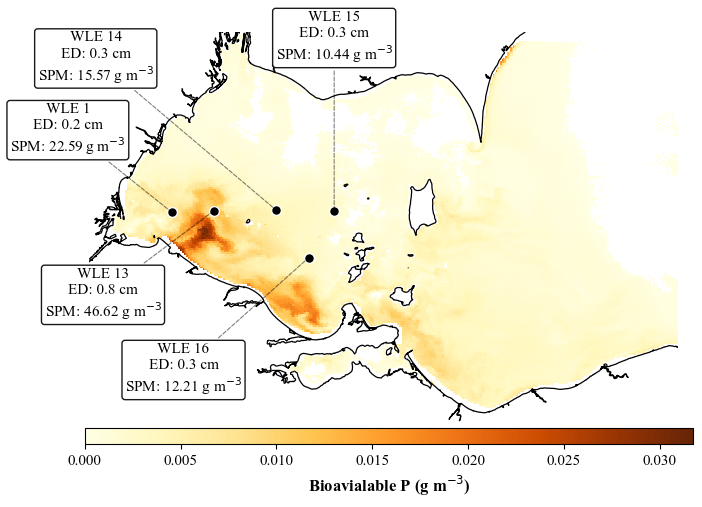

In [29]:
surf["SPM_g_m3"] = surf["SPM_g_m2"] / surf["water_depth_m"].replace({0: np.nan})

# --- Extent (Western Lake Erie) ------------------------

lon_min, lon_max, lat_min, lat_max = -83.5, -82, 41.25, 42.1

wb = surf[
    surf["lon"].between(lon_min, lon_max) &
    surf["lat"].between(lat_min, lat_max)
].copy()

# --- Projection setup ---------------------------------
proj_map = ccrs.UTM(17)  # UTM Zone 17N covers western Lake Erie
pc = ccrs.PlateCarree()

fig = plt.figure(figsize=(7.6, 6.1))
ax = fig.add_subplot(1, 1, 1, projection=proj_map)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=pc)


ax.add_geometries(
    med.geometry,
    crs=ccrs.PlateCarree(),
    facecolor="none", edgecolor="black", linewidth=0.9, zorder=6,
    label="Defined Coast (N40W085)"
)

# --- Land background ----------------------------------
ax.add_feature(cfeature.LAND, facecolor="white", edgecolor="0.6", linewidth=0.5, zorder=0)

# --- Optional raster overlay --------------------------
if "phos_subset_masked" in globals():
    vmax = float(phos_subset_masked_srp.max().values)
    im = ax.pcolormesh(
        phos_subset_masked_srp.lon,
        phos_subset_masked_srp.lat,
        phos_subset_masked_srp,
        cmap="YlOrBr", vmin=0, vmax=vmax, shading="auto",
        transform=pc, zorder=1
    )
    # Bottom-position colorbar
    cax = fig.add_axes([0.12, 0.19, 0.8, 0.025])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label("Bioavialable P (g m$^{-3}$)", fontsize=12, fontweight = 'bold')
    cbar.ax.tick_params(labelsize=11)

# --- Station markers ----------------------------------
ax.scatter(
    wb["lon"], wb["lat"], s=50,
    color="black", edgecolor="white",
    transform=pc, zorder=5
)

# --- Label placement rules ----------------------------
def norm(s): return str(s).upper().replace(" ", "")

which_side = {
    "WLE1":  "left",
    "WLE13": "left",
    "WLE14": "above",
    "WLE15": "right",
    "WLE16": "below"
}

# Default offsets (per side)
OFFSETS = {
    "left":  dict(x=-0.1, y=0.5, ha="right", va="center"),
    "right": dict(x=1.05, y=0.5, ha="left", va="center"),
    "above": dict(x=0.5, y=1.05, ha="center", va="bottom"),
    "below": dict(x=0.5, y=-0.04, ha="center", va="top"),
}

# Per-station manual tweaks (add only where needed)
# CUSTOM_OFFSETS = {
#     "WLE1":   dict(x=-0.12, y=0.55, ha="right", va="center"),
#     "WLE13":  dict(x=-0.08, y=0.45, ha="right", va="center"),
#     "WLE14":  dict(x=0.55,  y=1.10, ha="center", va="bottom"),
#     "WLE15": dict(x=1.05, y=0.5, ha="left", va="center"),
#     "WLE16": dict(x=0.5, y=-0.04, ha="center", va="top")
   
# }
OFFSET_PIXELS = {
    "WLE1":  (-75,  60),
    "WLE13": (-80, -60),
    "WLE14": ( -130,  110),
    "WLE15": ( 0,   125),
    "WLE16": (  -90, -80),
}

# --- Add labels OUTSIDE map ---------------------------
for _, r in wb.iterrows():
    station_id = norm(r["sample_id"])
    dx, dy = OFFSET_PIXELS.get(station_id, (20, 20))  # default if not in dict

    # full multi-line label
    ed_txt  = "NA" if pd.isna(r["ED_cm"])    else f"{float(r['ED_cm']):.1f}"
    spm_txt = "NA" if pd.isna(r["SPM_g_m3"]) else f"{float(r['SPM_g_m3']):.2f}"
    label   = f"{r['sample_id']}\nED: {ed_txt} cm\nSPM: {spm_txt} g m$^{{-3}}$"

    ax.annotate(
        label,
        xy=(r["lon"], r["lat"]), xycoords=pc,
        xytext=(dx, dy), textcoords="offset points",  # <-- pixel offsets
        ha="center", va="center",
        fontsize=11,
        bbox=dict(facecolor="white", alpha=0.9, boxstyle="round,pad=0.2"),
        arrowprops=dict(arrowstyle="-", color="black", lw=0.8, linestyle="--",        # <- dashed line
            alpha=0.5,             # <- transparency of line
            shrinkA=2, shrinkB=2),
        zorder=7
    )
# --- Legend -------------------------------------------
# ax.legend(
#     handles=[plt.Line2D([0],[0], marker="o", color="w",
#                         markerfacecolor="black", markeredgecolor="white",
#                         markersize=10, linestyle="None", label="Stations")],
#     loc="lower left", fontsize=14
# )

ax.axis("off")

# Save + show
plt.savefig(os.path.join(fig_dir, "F_bioP_wb_med.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [30]:
# Quick whole-lake summary
print("=== Approximate Lake Erie Summary (lat ≤ 42.1° N) ===")
print(f"TP valid pixels:  {int(np.isfinite(phos_subset_masked).sum())}")
print(f"SRP valid pixels: {int(np.isfinite(phos_subset_masked_srp).sum())}")
print(f"Mean TP conc (g/m³):  {float(phos_subset_masked.mean(skipna=True)):.6f}")
print(f"Mean SRP conc (g/m³): {float(phos_subset_masked_srp.mean(skipna=True)):.6f}")

=== Approximate Lake Erie Summary (lat ≤ 42.1° N) ===
TP valid pixels:  60178
SRP valid pixels: 60178
Mean TP conc (g/m³):  0.007443
Mean SRP conc (g/m³): 0.002339


In [31]:
# Convert concentration to mass per pixel (whole Lake Erie)

PIXEL_SIDE_M  = 300.0
PIXEL_AREA_M2 = PIXEL_SIDE_M ** 2     
D_eff_m       = 1.0              

TP_per_pixel_g_all  = phos_subset_masked  * D_eff_m * PIXEL_AREA_M2
SRP_per_pixel_g_all = phos_subset_masked_srp * D_eff_m * PIXEL_AREA_M2


# Whole-lake totals in grams

M_TP_total_g_all  = float(TP_per_pixel_g_all.sum(skipna=True))
M_SRP_total_g_all = float(SRP_per_pixel_g_all.sum(skipna=True))

 # g to kg
M_TP_total_kg_all  = M_TP_total_g_all  / 1e3    
M_SRP_total_kg_all = M_SRP_total_g_all / 1e3

# g to metric tons
# M_TP_total_t_all   = M_TP_total_g_all  / 1e6
# M_SRP_total_t_all  = M_SRP_total_g_all / 1e6

print("Whole Lake Erie total P mass (approx. lat ≤ 42.1 °N)")
print(f"Total TP  :   {M_TP_total_kg_all:,.0f} kg")
print(f"Total SRP :  {M_SRP_total_kg_all:,.0f} kg")

Whole Lake Erie total P mass (approx. lat ≤ 42.1 °N)
Total TP  :   40,314 kg
Total SRP :  12,665 kg


### Figure 5 inset for windrose

In [32]:
DATA_GLOB = str(WIND_DIR / 'thro1h*.txt')  

COLS = ['YY','MM','DD','hh','mm','WDIR','WSPD','GST','WVHT','DPD','APD',
        'MWD','PRES','ATMP','WTMP','DEWP','VIS','TIDE']


In [33]:
def load_one(path: str) -> pd.DataFrame:
    # See first line to decide skiprows
    with open(path, "r", errors="ignore") as f:
        first = f.readline().strip()
    # If first token isn't all digits (e.g., 'YYYY'), skip the first line
    skiprows = 1 if (len(first) > 0 and not first.split()[0].isdigit()) else 0

    df = pd.read_csv(
        path,
        delim_whitespace=True,
        names=COLS,
        comment="#",
        skiprows=skiprows,
        na_values=["99","99.0","99.00","999","999.0","999.00","MM","MM.MM"]
    )
    # Some feeds may already have full 4-digit year. Try to detect.
    # If YY appears > 1900, treat as full year. Otherwise add 2000.
    yy = pd.to_numeric(df["YY"], errors="coerce")
    if (yy >= 1900).any():
        year = yy
    else:
        year = yy + 2000
    df["year"] = year

    # Build datetime; coerce errors
    df["dt"] = pd.to_datetime(
        dict(year=df["year"], month=df["MM"], day=df["DD"], hour=df["hh"], minute=df["mm"]),
        errors="coerce"
    )
    # Keep only relevant columns and valid rows
    keep = df[["dt","year","WDIR","WSPD"]].copy()
    keep["WDIR"] = pd.to_numeric(keep["WDIR"], errors="coerce")
    keep["WSPD"] = pd.to_numeric(keep["WSPD"], errors="coerce")

    keep = keep.dropna(subset=["dt","WDIR","WSPD"])
    # Remove sentinels and calms
    keep = keep[(keep["WDIR"]>=0) & (keep["WDIR"]<=360)]
    keep = keep[keep["WSPD"]>0.1]
    return keep

In [34]:
# Load all files in range 2005–2023
paths = sorted(glob.glob(DATA_GLOB))
frames = []
for p in paths:
    try:
        df1 = load_one(p)
        # Filter to target year range
        df1 = df1[(df1["year"]>=2005) & (df1["year"]<=2023)]
        if not df1.empty:
            frames.append(df1)
    except Exception as e:
        print(f"Skipping {p}: {e}")

if not frames:
    print("No usable files found. Check DATA_GLOB or file format.")
else:
    wind = pd.concat(frames, ignore_index=True)

    # ---- Build binned windrose ----
    dir_step = 30  # sector size in degrees
    dir_edges = np.arange(0, 360+dir_step, dir_step)
    dir_centers = (dir_edges[:-1] + dir_edges[1:]) / 2.0
    dir_centers_rad = np.deg2rad(dir_centers)

    speed_bins = (0, 2, 4, 6, 8, 10, 15, 20, 30)  # m/s classes
    labels = [f"{speed_bins[i]}–{speed_bins[i+1]} m/s" for i in range(len(speed_bins)-1)]

    # Digitize
    d_idx = np.digitize(wind["WDIR"].to_numpy() % 360, dir_edges) - 1
    s_idx = np.digitize(wind["WSPD"].to_numpy(), speed_bins) - 1

    # Counts
    counts = np.zeros((len(speed_bins)-1, len(dir_centers)), dtype=float)
    valid = (d_idx>=0) & (d_idx<len(dir_centers)) & (s_idx>=0) & (s_idx<len(speed_bins)-1)
    for d, s in zip(d_idx[valid], s_idx[valid]):
        counts[s, d] += 1.0

    # Normalize to percentages of total samples
    total = counts.sum()
    if total > 0:
        counts = counts * 100.0 / total

/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3160546890.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3160546890.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3160546890.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3160546890.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/tb/sn9xqkx9

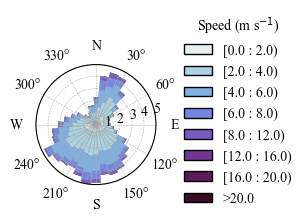

In [35]:

ws = wind["WSPD"].to_numpy()
wd = wind["WDIR"].to_numpy()

# -----------------------
# Speed bins
# -----------------------
speed_bins = [0, 2, 4, 6, 8, 12, 16, 20]
n_bins = len(speed_bins) - 1  # 8 bins

# Discrete colors: generate one extra so that the last ">20" gets its own
cmap = cmocean.cm.dense
colors = [cmap(x) for x in np.linspace(0, 1, n_bins+1)]
cmap_discrete = ListedColormap(colors)

# -----------------------
# Windrose plot
# -----------------------
plt.rcParams["font.family"] = "Times New Roman"
TITLE_SIZE        = 16
THETA_TICK_SIZE   = 12
RADIAL_TICK_SIZE  = 12
LEGEND_TEXT_SIZE  = 10
LEGEND_TITLE_SIZE = 11

fig = plt.figure(figsize=(1.5, 1.5))
ax = WindroseAxes.from_ax(fig=fig)

ax.bar(
    wd, ws,
    bins=speed_bins,
    cmap=cmap_discrete,
    nsector=36,
    opening=0.96,
    edgecolor="gray", lw=0.2,
    normed=True
)

# Orientation: North up, clockwise
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Direction labels every 30°
angles = np.arange(0, 360, 30)
theta_labels = ["N","30°","60°","E","120°","150°","S","210°","240°","W","300°","330°"]
ax.set_thetagrids(angles, labels=theta_labels, fontsize=10)

# Radial gridlines with %
ax.grid(True, linestyle="--", linewidth=0.4)
ax.set_yticklabels([])
angle_rad = np.deg2rad(75)

# Get the current radial tick values (excluding 0 at center)
yticks = ax.get_yticks()

# Add them manually
for t in yticks:
    ax.text(
        angle_rad,              # angle position
        t*1.05,                 # radius (1.05 pushes outward, adjust as needed)
        f"{t:.0f}",             # the label text
        ha="center", va="center",
        fontsize=10,
        rotation=0,
        rotation_mode="anchor"
    )

# Legend
# -----------------------
labels = [f"{speed_bins[i]}–{speed_bins[i+1]}" for i in range(n_bins)]
labels[-1] = f">{speed_bins[-2]}"  # last bin is ">20"

leg = ax.set_legend(
    labels=labels,
    title="Speed (m s$^{-1}$)",
    loc=(1.19, -0.22),
    fontsize=10, frameon=False 
)
for txt in leg.get_texts():
    txt.set_fontsize(LEGEND_TEXT_SIZE)
    txt.set_fontfamily("Times New Roman")
if leg and leg.get_title():
    leg.get_title().set_fontsize(10)
    
plt.savefig(os.path.join(fig_dir, "windrose_final.png"), dpi=400, bbox_inches='tight')
plt.show()

## Figure 2: Be-7 distribution across stations and months

In [36]:
be_2023 = pd.read_csv(SEDIMENT_DIR / 'be_7_activity_2023.csv')
be_2024 = pd.read_csv(SEDIMENT_DIR / 'be_7_activity_2024.csv')


In [37]:
# --- Normalize depth labels like "0–1 cm", "0 - 1cm", "0—1 CM" -> "0-1"
_dash_rx = re.compile(r"[–—−]")  # en/em/minus -> hyphen

def normalize_depth_label(s: str) -> str:
    if pd.isna(s): return ""
    t = str(s).strip()
    t = _dash_rx.sub("-", t)      # normalize dashes
    t = t.replace("CM", "cm")
    t = t.replace(" ", "")        # drop spaces
    t = t.replace("cm", "")       # drop suffix
    m = re.match(r"^(\d+)-(\d+)$", t)
    if not m: return t
    a, b = m.groups()
    return f"{int(a)}-{int(b)}"   # canonical

def prep_pivot(df, month_order):
    """Return pivot (rows=station_month, cols=depth bins shallow->deep) and ordered depths."""
    _df = df.copy()
    _df['month']   = pd.Categorical(_df['month'], categories=month_order, ordered=True)
    _df['station'] = _df['station'].astype(str).str.strip()
    _df            = _df[_df['month'].notna()].copy()

    _df['depth_key'] = _df['depth (cm)'].apply(normalize_depth_label)
    _df['station_month'] = _df['station'] + ' ' + _df['month'].astype(str)

    station_month_order = sorted(
        _df['station_month'].unique(),
        key=lambda x: (x.split()[0], month_order.index(x.split()[1]))
    )
    _df['station_month'] = pd.Categorical(_df['station_month'],
                                          categories=station_month_order, ordered=True)

    pivot = _df.pivot_table(
        index='station_month',
        columns='depth_key',
        values='Be-7(dpm/cm3)',
        aggfunc='sum'
    )

    depths = sorted(pivot.columns, key=lambda s: int(s.split('-')[0]))  # shallow -> deep
    pivot  = pivot[depths]
    return pivot, depths

def plot_core_stack_with_totals(ax, pivot, depths, title, color_map, y_max=None):
    """Stack shallow->deep, flip y so 0 is at top, and annotate with SUM across depths."""
    # Numeric x so annotations align perfectly
    x = np.arange(len(pivot.index))

    # Stack bars
    bottoms = np.zeros(len(pivot), dtype=float)
    for d in depths:  # shallow -> deep
        vals = pivot[d].fillna(0).to_numpy()
        ax.bar(x, vals, bottom=bottoms, color=color_map[d], width=0.55, label=f"{d} cm")
        bottoms += vals

    # Totals (sum across depths) per bar
    totals = pivot[depths].fillna(0).sum(axis=1).to_numpy()

    # Top-down orientation
    local_max = float(np.nanmax(totals)) if totals.size else 1.0
    ymax = y_max if y_max is not None else (1.08 * local_max if local_max > 0 else 1.0)
    ax.set_ylim(ymax, 0)

    # Annotate totals just past the end of each stack (downward, since axis is flipped)
    pad = 0.02 * ymax
    for xi, tot in zip(x, totals):
        y_end = float(tot)
        # Place label slightly "below" the bar end (larger y due to inverted axis)
        ax.text(xi, y_end + pad, f"{tot:.2f}",
                ha='center', va='top', fontsize=9)

    # X on top, show only month names
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(x)
    month_labels = [idx.split()[-1] for idx in pivot.index]
    ax.set_xticklabels(month_labels, fontsize=16, rotation=45)

    ax.set_title(title, fontsize=20, fontweight ='bold')
    ax.grid(False)
    ax.tick_params(axis='y', labelsize=16)

    return ymax, totals

### Figure 2a:  Be-7 distribution for 2023

/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3083494856.py:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = _df.pivot_table(
/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/1276525922.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('OrRd')


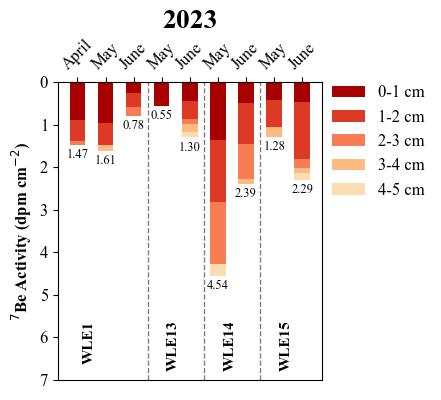

In [38]:
# ===================== 2023 Only Plot =====================

pivot_2023, depths_2023 = prep_pivot(be_2023, month_order=['April', 'May', 'June'])

cmap = mpl.cm.get_cmap('OrRd')
palette = [mpl.colors.to_hex(cmap(v)) for v in np.linspace(0.9, 0.2, len(depths_2023))]
color_map = {d: palette[i] for i, d in enumerate(depths_2023)}

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.1))

_, totals_2023 = plot_core_stack_with_totals(ax, pivot_2023, depths_2023, '2023', color_map)

# Adjust y-limit
ax.set_ylim(7, 0)
ax.set_ylabel('$^7$Be Activity (dpm cm$^{-2}$)', fontsize=12, fontweight='bold')

# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[d], ec='none') for d in depths_2023]
labels  = [f'{d} cm' for d in depths_2023]
ax.legend(handles, labels,
          bbox_to_anchor=(0.98, 1.04), loc='upper left',
          fontsize=12, frameon=False)

# Number of months per station = how many columns belong to each station
n_months = len(pivot_2023.index.categories[0].split()) - 1  # if 'WLE13 April' etc.
# Better: detect unique months
n_months = len(pivot_2023.index[0].split())  # check how station_month is constructed

# Or simply count unique months passed to prep_pivot
n_months = 3   # ['April','May','June']  <-- adjust  data

# Get station order from pivot index
station_names = sorted(set(idx.split()[0] for idx in pivot_2023.index))

station_names = [idx.split()[0] for idx in pivot_2023.index]  # e.g. ["WLE1 April", ...]
unique_stations = []
station_bounds = {}

# Find start and end x-positions for each station
for i, st in enumerate(station_names):
    if st not in unique_stations:
        unique_stations.append(st)
        station_bounds[st] = [i, i]  # start, end
    else:
        station_bounds[st][1] = i    # update end

# Draw dashed lines and labels
for j, st in enumerate(unique_stations):
    start, end = station_bounds[st]
    center = start + (n_months-1)/10

    # vertical dashed line after this station (skip last)
    if j < len(unique_stations) - 1:
        ax.axvline(end + 0.5, color="gray", linestyle="--", linewidth=1)

    # station label below bars
    ax.text(center, ax.get_ylim()[0] - 1.4, st,
            ha="left", va="top",
            fontsize=11, fontweight="bold", rotation=90,
            clip_on=False)

# make tick labels larger
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "F_Be7_stack_2023.png"), dpi=400, bbox_inches='tight')
plt.show()


### Figure 2b:  Be-7 distribution for 2024

/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3083494856.py:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = _df.pivot_table(
/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3190924014.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('OrRd')


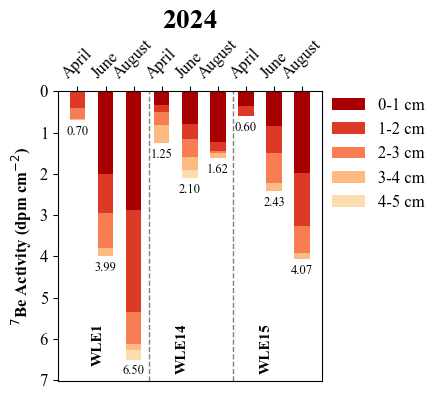

In [39]:
# ===================== 2024 Be-7 Plot =====================

# Prepare pivot for 2024
pivot_2024, depths_2024 = prep_pivot(be_2024, month_order=['April', 'June', 'August'])

# Consistent colors (shallow->deep)
cmap = mpl.cm.get_cmap('OrRd')
palette = [mpl.colors.to_hex(cmap(v)) for v in np.linspace(0.9, 0.2, len(depths_2024))]
color_map = {d: palette[i] for i, d in enumerate(depths_2024)}

# --- Plot ---
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.1))

_, totals_2024 = plot_core_stack_with_totals(ax, pivot_2024, depths_2024, '2024', color_map)

# Adjust y-limit based on data
common_ymax = 1.08 * float(np.nanmax(totals_2024) if totals_2024.size else 1.0)
ax.set_ylim(common_ymax, 0)
ax.set_ylabel('$^7$Be Activity (dpm cm$^{-2}$)', fontsize=12, fontweight='bold')

# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[d], ec='none') for d in depths_2024]
labels  = [f'{d} cm' for d in depths_2024]
ax.legend(handles, labels,
          bbox_to_anchor=(0.98, 1.03), loc='upper left',
          fontsize=12, frameon=False)

# --- Add dashed separators + station labels ---
stations = ["WLE1", "WLE14", "WLE15"]  # order matches pivot
n_months = 3  # April, June, August

for i, st in enumerate(stations):
    start = i * n_months
    end   = (i+1) * n_months - 0.5

    # vertical dashed line after each station (skip last)
    if i < len(stations) - 1:
        ax.axvline(end + 0.05, color="gray", linestyle="--", linewidth=1)

    # station name centered under its 3 months
    center = start + (n_months-1)/4
    ax.text(center, ax.get_ylim()[0] - 1.4, st,
            ha="left", va="top",
            fontsize=11, fontweight="bold", rotation=90,
            clip_on=False)

# Bigger ticks
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "F_Be7_stack_2024.png"), dpi=400, bbox_inches='tight')
plt.show()

## Figure 3: Sediment phosphorus speciation and variability

In [40]:
p_data = pd.read_csv(SEDIMENT_DIR / 'p_fractionation_core_data_2023.csv')


### Figure 3a: Relative depth profiles of P fractions

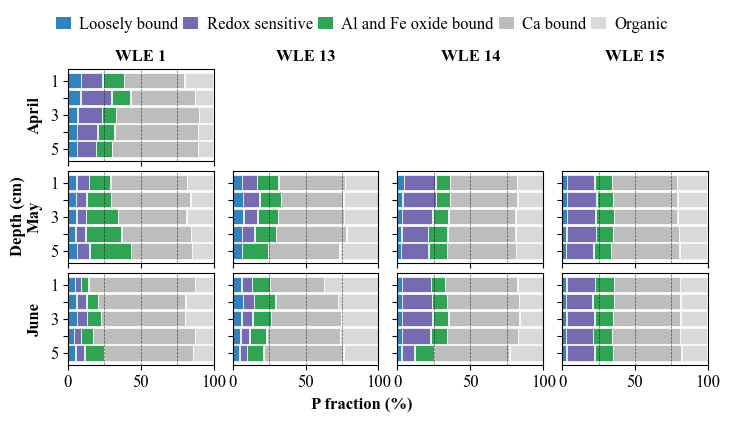

In [41]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
df = p_data.copy()
df.columns = [c.strip() for c in df.columns]
df["Month"]   = df["Month"].astype(str).str.strip().str.capitalize()
df["Station"] = (df["Station"].astype(str)
                 .str.strip()
                 .str.replace(r"(?i)\bWLE[\s\-]*", "WLE ", regex=True)
                 .str.replace(r"\s+", " ", regex=True))
df["Depth"]   = pd.to_numeric(df["Depth"], errors="coerce")

# --------- FRACTIONS ----------
order = ["NaCl", "NaBD", "NaOH", "HCl", "RP"]
stacked_fractions = [f for f in order if f in df.columns]
if not stacked_fractions:
    raise ValueError("No expected fraction columns present in the dataframe.")

fraction_names = {
    "NaCl": "Loosely bound",
    "NaBD": "Redox sensitive",
    "NaOH": "Al and Fe oxide bound",
    "HCl":  "Ca bound",
    "RP":   "Organic",
}
fraction_hex = {
    "NaCl": "#3182bd", "NaBD": "#756bb1", "NaOH": "#31a354",
    "HCl": "#bdbdbd", "RP": "#d9d9d9"
}
fraction_colors = {f: fraction_hex[f] for f in stacked_fractions}

# --------- LAYOUT: months × stations ----------
months = ["April", "May", "June"]

def _station_sort_key(s):
    parts = s.split()
    num = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else 999
    return (parts[0], num)

stations_by_month = {
    m: sorted(
        df.loc[df["Month"] == m, "Station"].dropna().unique().tolist(),
        key=_station_sort_key
    )
    for m in months
}
max_cols = max(max(1, len(stations_by_month[m])) for m in months)
# Take union of all stations across months
all_stations = sorted(set().union(*stations_by_month.values()), key=_station_sort_key)
nrows, ncols = len(months), len(all_stations)

fig, axes = plt.subplots(
    nrows=len(months), ncols=max_cols,
    figsize=(2*max_cols, 1.4*len(months)),
    sharex=True, sharey=False  # depth ticks can differ per station
)
axes = np.atleast_2d(axes)


# --------- Plotting loop ----------
for r, month in enumerate(months):
    for c, station in enumerate(all_stations):
        ax = axes[r, c]
        subset = df[(df["Station"] == station) & (df["Month"] == month)]
        subset = subset[["Depth"] + stacked_fractions].dropna(subset=["Depth"])
        if subset.empty:
            ax.set_axis_off()
            continue

        grouped = (subset.groupby("Depth")[stacked_fractions]
                          .mean()
                          .sort_index())
        row_sums = grouped.sum(axis=1).replace(0, np.nan)
        grouped_norm = (grouped.div(row_sums, axis=0) * 100.0).fillna(0.0)

        y = grouped_norm.index.values
        
        gap = 0.3  # spacing in % between fractions
        left = np.zeros(len(grouped_norm), dtype=float)

        for frac in stacked_fractions:
            vals = grouped_norm[frac].values

            # reduce each bar width to leave a small gap
            vals_adj = np.maximum(vals - gap, 0)  # avoid negatives

            ax.barh(y, vals_adj, height=0.9, left=left,
                    color=fraction_colors[frac], edgecolor='white', linewidth=0.5)
            left += vals  
        # still use full width for stacking positions
        for x in [25, 50, 75]:
            ax.axvline(x, color="black", linestyle="--", linewidth=0.5, alpha=0.6)

        # Ensure x-axis ticks are shown at same positions
        ax.set_xticks([0, 25, 50, 75, 100])
        ax.set_xticklabels([0, 25, 50, 75, 100], fontsize=12)

        ax.set_xlim(0, 100)
        ax.set_xticks([0, 50, 100])
        ax.set_yticks([1,2,3,4,5])
        ax.set_yticklabels(["1","","3","","5"], fontsize=12)
        ax.invert_yaxis()

        # Hide tick labels except leftmost and bottom row
        if c > 0:
            ax.set_yticklabels([])
        if r < nrows-1:
            ax.set_xticklabels([])

# --------- Row labels (Months) ---------
for r, month in enumerate(months):
    axes[r,0].set_ylabel(month, fontsize=12, fontweight="bold", rotation=90, labelpad=5)

# --------- Column labels (Stations) ---------
for c, station in enumerate(all_stations):
    axes[0,c].set_title(station, fontsize=12, fontweight="bold")

# --------- Global labels ---------
fig.text(0.5, 0.04, "P fraction (%)", ha="center", fontsize=12, fontweight="bold")
fig.text(0.06, 0.5, "Depth (cm)", va="center", rotation="vertical", fontsize=12, fontweight="bold")

# --------- LEGEND (two rows, spanning all empty April cells) ---------
legend_handles = [Patch(facecolor=fraction_colors[f], label=fraction_names.get(f, f))
                  for f in stacked_fractions]
legend_labels = [h.get_label() for h in legend_handles]
n = len(legend_handles)
ncol_two_rows = int(np.ceil(n / 1.0))  # force two rows

april_cols = len(stations_by_month["April"])
legend_drawn = False

# Identify all empty April cells: from 'april_cols' through last column
empty_cols = list(range(april_cols, max_cols))

if empty_cols:
    # Turn off those empty cells (they just serve to reserve space)
    for c in empty_cols:
        axes[0, c].set_axis_off()

    # Compute the union bbox of all empty April cells (AFTER tight_layout)
    bboxes = [axes[0, c].get_position() for c in empty_cols]
    x0 = min(b.x0 for b in bboxes)
    y0 = min(b.y0 for b in bboxes)
    x1 = max(b.x1 for b in bboxes)
    y1 = max(b.y1 for b in bboxes)
    union = [x0, y0, (x1 - x0), (y1 - y0)]

# Legend
if not legend_drawn:
    fig.legend(
        handles=legend_handles,
        labels=legend_labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.01),
        ncol=ncol_two_rows,
        frameon=False,
        handlelength=0.9,
        columnspacing=0.3,
        handletextpad=0.5,
        labelspacing=0.35,
        prop={"size": 12}
    )

plt.tight_layout(rect=[0.08,0.08,0.95,0.9], pad = 0.1, w_pad = 0.1, h_pad = 0.3)
plt.savefig(os.path.join(fig_dir, "F_percent_p_fraction_horizontal.png"), dpi=500, bbox_inches='tight')
plt.show()


### Figure 3b: Boxplots of phosphorus concentrations

In [42]:
fractions = ["NaCl", "NaBD", "NaOH", "HCl", "RP", "TP"]

# --- Fonts / style (optional, Times + clean) ---
sns.set_theme(style="white", rc={"axes.grid": False})
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times"],
    "mathtext.fontset": "custom",
    "mathtext.rm": "Times New Roman",
    "mathtext.it": "Times New Roman:italic",
    "mathtext.bf": "Times New Roman:bold",
    "axes.unicode_minus": False,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

# --- Base families for each fraction (defaults you can keep/override) ---
frac2cmap = {
    "NaCl": "Blues",    # Loosely bound
    "NaBD": "Greens",  # Redox sensitive
    "NaOH": "Purples",  # Al & Fe oxide bound
    "HCl":  "Oranges",   # Ca bound
    "RP":   "YlGn",     # Organic
    "TP":   "YlOrBr",   # Total (browns)
}

def shades_from_cmap(cmap_name, reverse=True, levels=(0.20, 0.50, 0.85)):
    """Return 3 hex shades from cmap (dark, mid, light)."""
    cmap = mpl.colormaps[cmap_name + ('_r' if reverse else '')]
    return [mpl.colors.to_hex(cmap(v)) for v in levels]

# Build base palettes: April=dark, May=mid, June=light
base_palettes = {}
for frac in fractions:
    if frac in frac2cmap:  # skip missing
        dark, mid, light = shades_from_cmap(frac2cmap[frac], reverse=True)
        base_palettes[frac] = {"April": dark, "May": mid, "June": light}

# -------- OVERRIDES: set any month color for any fraction here --------
# Example: tweak specific months for given fractions (leave others as base)
overrides = {
    "NaCl": {  # Loosely bound → custom blues
        "April": "#deebf7",
        "May":   "#9ecae1",
        "June":  "#3182bd",
    },
    "NaBD": {  # Redox → Purple
        "April": "#efedf5",
        "May":   "#bcbddc",
        "June":  "#756bb1",
    },
    "NaOH": {  # Greens
        "April": "#e5f5e0",
        "May":   "#a1d99b",
        "June":  "#31a354",
    },
    "TP": {    #Purples
        "April": "#fee6ce",
        "May":   "#fdae6b",
        "June":  "#e6550d",
    },
    # Add more fractions/months as needed...
}

def build_palettes(base_palettes: dict, overrides: dict = None, months=("April","May","June")) -> dict:
    """Merge base palettes with per-fraction, per-month overrides."""
    out = {f: base_palettes.get(f, {}).copy() for f in base_palettes}
    if overrides:
        for frac, mo in overrides.items():
            out.setdefault(frac, {})
            for m, col in mo.items():
                if m not in months:
                    raise ValueError(f"Unknown month '{m}'. Valid: {months}")
                out[frac][m] = mpl.colors.to_hex(col)
    return out

fraction_palettes = build_palettes(base_palettes, overrides, months=tuple(months))

# --- (Optional) helper to change one color on the fly ---
def set_fraction_month_color(fraction_palettes: dict, frac: str, month: str, color: str):
    fraction_palettes.setdefault(frac, {})
    fraction_palettes[frac][month] = mpl.colors.to_hex(color)

# set_fraction_month_color(fraction_palettes, "RP", "May", "#8fd18f")

# --- Station order (nice numeric sort for 'WLE 1', 'WLE 10', ...) ---
def _station_sort_key(s):
    parts = s.split()
    num = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else 1_000_000
    return (parts[0], num)
station_order = sorted(df["Station"].unique().tolist(), key=_station_sort_key)

/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3250450295.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=22)
/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3250450295.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=22)
/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3250450295.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=22)
/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3250450295.py:73: UserWarning: set_ticklabels() should only

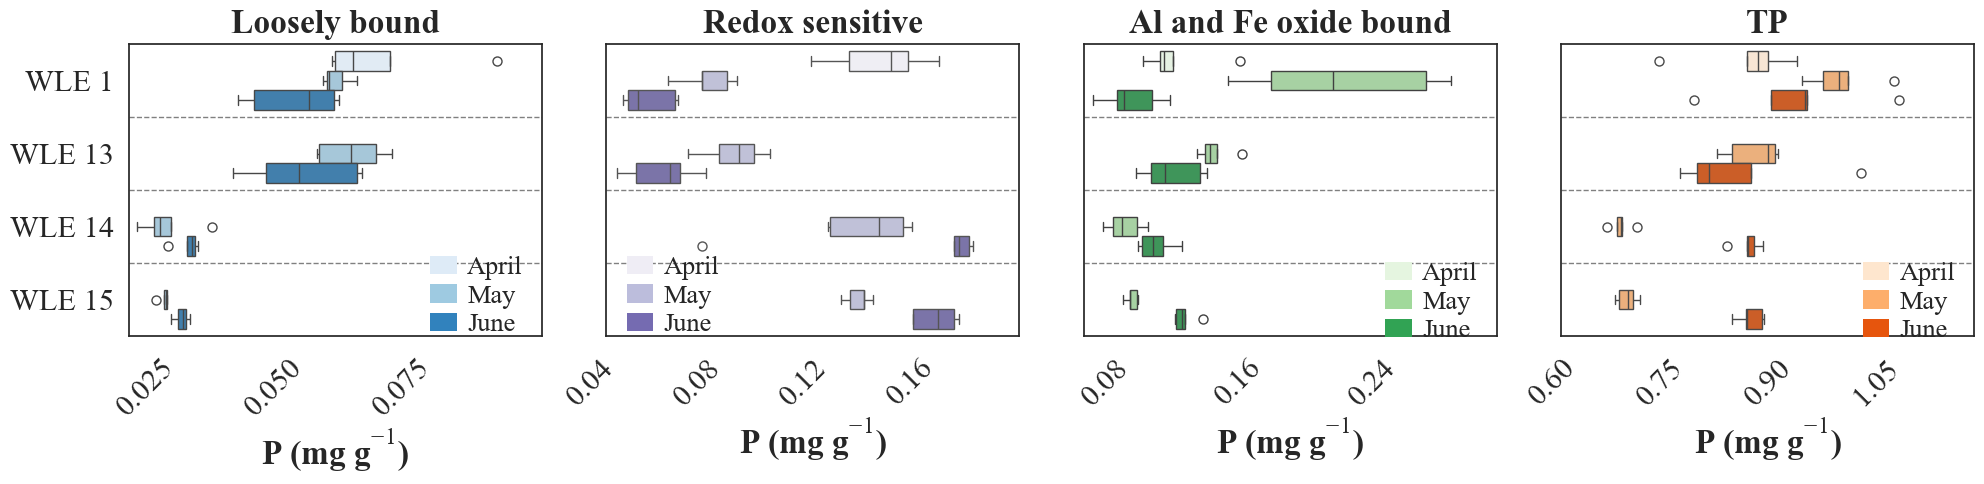

In [43]:

# --- Select fractions to plot ---
fractions_to_plot = ["NaCl", "NaBD", "NaOH", "TP"]

fig, axes = plt.subplots(
    nrows=1, ncols=len(fractions_to_plot),
    figsize=(5*len(fractions_to_plot), 5),
    sharey=True
)

if len(fractions_to_plot) == 1:
    axes = [axes]  # make iterable

for ax, frac in zip(axes, fractions_to_plot):
    pal = fraction_palettes.get(frac, {m: "#999999" for m in months})

    sns.boxplot(
        data=df, x=frac, y="Station", hue="Month",
        hue_order=months, order=station_order,
        palette=pal, linewidth=1, ax=ax,
        flierprops={"marker": "o", "markersize": 6.5}
    )

    if ax.get_legend() is not None:
        ax.legend_.remove()

    handles = [Patch(facecolor=pal[m], edgecolor="none", label=m)
               for m in months if m in pal]

    legend_pos = {
        "NaCl": ("lower right", (0.98, -0.04)),
        "NaOH": ("upper right", (0.98, 0.29)),
        "TP":   ("upper right", (0.98, 0.29)),
        "NaBD": ("lower right", (0.3, -0.04)),
    }
    loc, anchor = legend_pos.get(frac, ("upper left", (0.02, 0.98)))

    ax.legend(
        handles=handles,
        loc=loc, bbox_to_anchor=anchor,
        bbox_transform=ax.transAxes,
        frameon=False, fontsize=19,
        ncol=1, borderaxespad=0.0,
        labelspacing=0.15, handlelength=1.0, handletextpad=0.4
    )

    # --- Linear x-axis with limits ---
    xmin, xmax = df[frac].min(), df[frac].max()
    ax.set_xlim(xmin*0.9, xmax*1.1)
    ax.set_xscale("linear")
    ax.set_title(fraction_names.get(frac, frac), fontsize=24, pad=8, fontweight='bold')
    ax.set_xlabel("P (mg g$^{-1}$)", fontsize=24, fontweight="bold")
    ax.set_ylabel("")

    # Add this: force 4 x-axis tick labels per plot
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))

    # --- ticks ---
    ax.tick_params(
        axis="x",
        direction="out",
        length=7, width=1.5, top=False,
        labelsize=22,
        pad=6
    )
    ax.tick_params(
        axis="y",
        direction="out",
        length=7, width=1.5, right=False,
        labelsize=22
    )

    # --- Rotate x-tick labels ---
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=22)
    
    # --- Add dashed horizontal lines to separate stations ---
    yticks = range(len(station_order))
    for y in yticks[:-1]:
        ax.axhline(y + 0.5, color="gray", linestyle="--", linewidth=1)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "F_fraction_boxplots.png"), dpi=500, bbox_inches='tight')
plt.show()

# Supplementary Figures

In [44]:
#Db ESTIMATION BY FXING AT AS SURFACE ACTIVITY AT 1 CM AND TAKING SQUARE ROOT OF THE DB 

def estimate_Db_fixed_AT(
    df,
    depth_col='depth (cm)',
    activity_col='Be-7(dpm/cm3)',
    group_cols=['station', 'month'],
    min_points=2
):
    """
    Estimate Db (cm²/yr) by fitting an exponential Be-7 profile:
        A(z) = A_T * exp( -sqrt(lambda/Db) * z )
    where A_T is fixed as the surface activity.
    """

    # Convert depth intervals like "0-1" → midpoint 0.5
    def midpoint(s):
        a, b = str(s).replace('–', '-').split('-')
        return (float(a) + float(b)) / 2

    # Create numeric depth column
    df['depth (cm)'] = (
        df[depth_col].apply(midpoint) if df[depth_col].dtype == object else df[depth_col]
    )

    # Standardize activity column and remove missing values
    df = df.rename(columns={activity_col: 'Activity'}).dropna(subset=['Activity'])

    # Be-7 decay constant in 1/year (half-life = 53.2 days)
    lambda_yr = np.log(2) / (53.2 / 365.25)

    # Exponential model with A_T fixed
    def model_fixed(z, Db, AT_fixed):
        return AT_fixed * np.exp(-(np.sqrt(lambda_yr / Db)) * z)

    results = []

    # Fit Db within each station/month group
    for name, group in df.groupby(group_cols):
        z = group['depth (cm)'].values
        A = group['Activity'].values

        if len(z) >= min_points:
            # Sort by depth
            idx = np.argsort(z)
            z, A = z[idx], A[idx]

            AT_fixed = A[0]  # surface activity

            # Fit only Db (A_T is fixed)
            try:
                fit, _ = curve_fit(lambda z, Db: model_fixed(z, Db, AT_fixed),
                                   z, A, bounds=(1, 200))
                Db_est = fit[0]
            except RuntimeError:
                Db_est = np.nan

            # Store output
            result = {col: val for col, val in zip(group_cols, name)}
            result.update({
                'A_T fixed (dpm/cm³)': round(AT_fixed, 4),
                'D_b (cm²/yr)': round(Db_est, 2) if Db_est == Db_est else np.nan
            })
            results.append(result)

    return pd.DataFrame(results)

In [45]:
db_2023 = estimate_Db_fixed_AT(
    be_2023,
    depth_col='depth (cm)',
    activity_col='Be-7(dpm/cm3)',
    group_cols=['station', 'month']
)

output_directory = SEDIMENT_DIR
db_2023.to_csv(output_directory / '2023_Db.csv', index=False)
print(db_2023)


  station  month  A_T fixed (dpm/cm³)  D_b (cm²/yr)
0    WLE1  April               0.8900         14.60
1    WLE1   June               0.2559         70.51
2    WLE1    May               0.9500         15.94
3   WLE13   June               0.4443         69.60
4   WLE13    May               0.5479          5.43
5   WLE14   June               0.4900        200.00
6   WLE14    May               1.3605        106.76
7   WLE15   June               0.4688        200.00
8   WLE15    May               0.4160        136.51


In [46]:
db_2024 = estimate_Db_fixed_AT(
    be_2024,
    depth_col='depth (cm)',
    activity_col='Be-7(dpm/cm3)',
    group_cols=['station', 'month']
)

output_directory = SEDIMENT_DIR
db_2024.to_csv(output_directory / '2024_Db.csv', index=False)
print(db_2024)


  station   month  A_T fixed (dpm/cm³)  D_b (cm²/yr)
0    WLE1   April               0.0000        100.50
1    WLE1  August               2.8874         29.80
2    WLE1    June               1.9989         22.56
3   WLE14   April               0.3409        200.00
4   WLE14  August               1.2354          8.25
5   WLE14    June               0.7833         56.48
6   WLE15   April               0.3497         17.48
7   WLE15  August               1.9893         23.89
8   WLE15    June               0.8431         66.61


## Supplementary Figure 1a and b: Mixing rates (Db) based on ⁷Be profiles

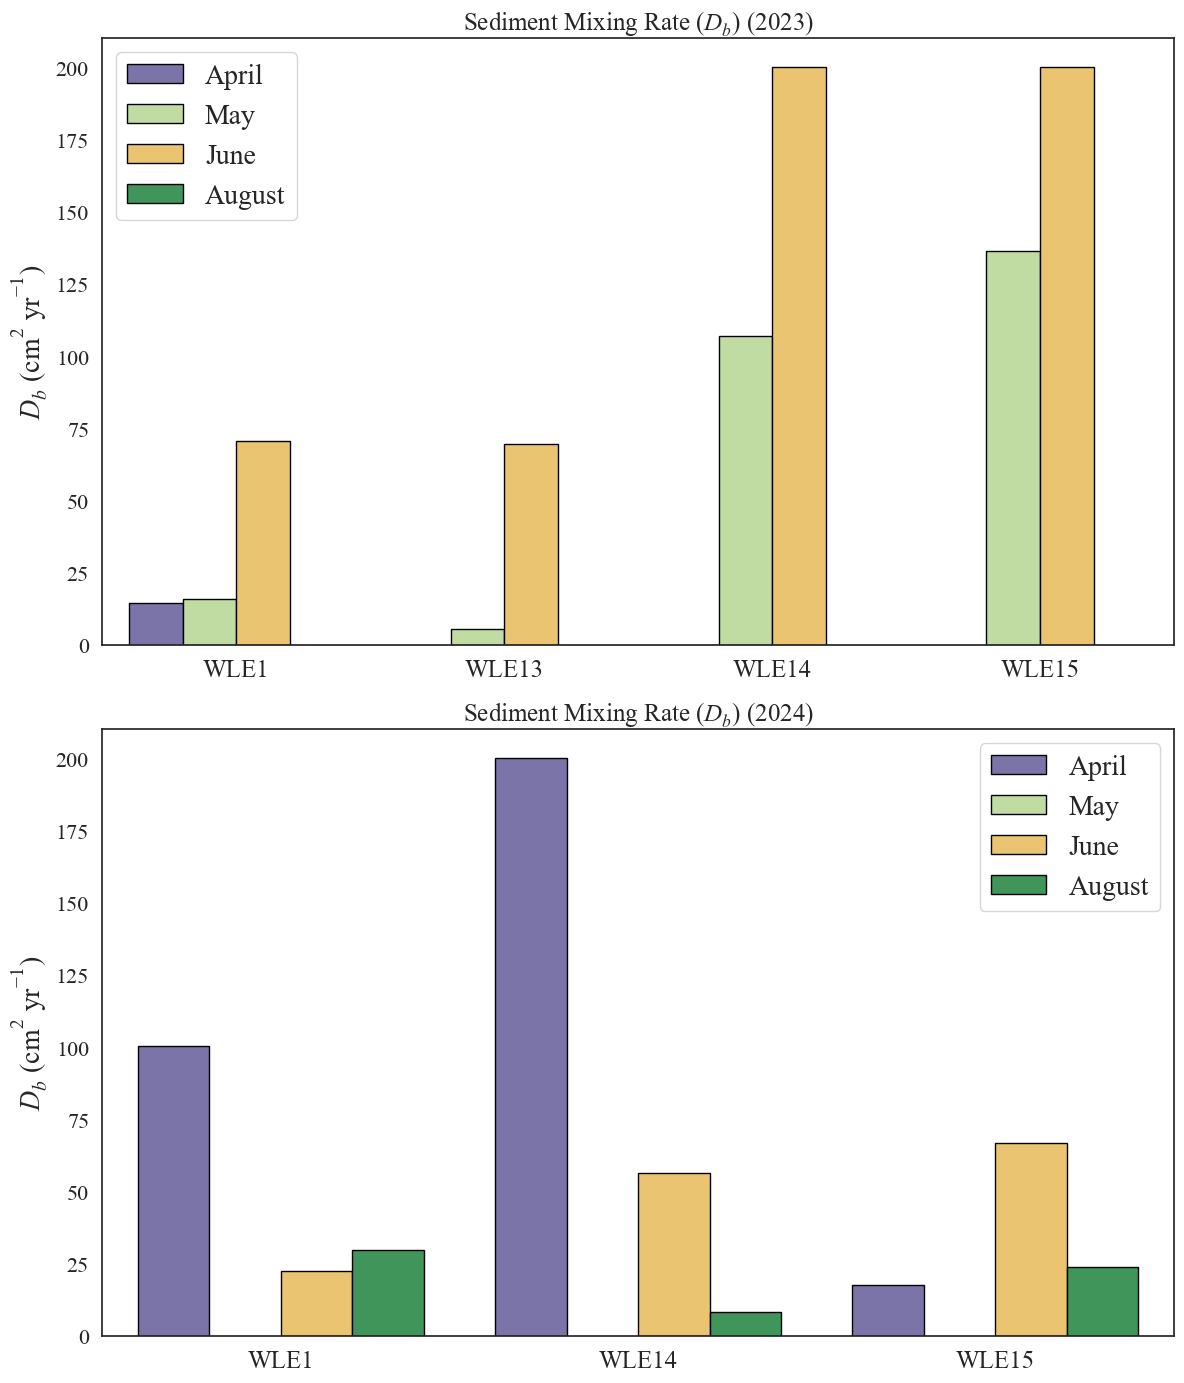

In [47]:
plt.rcParams['font.family'] = 'Times New Roman'
db_2023['Year'] = '2023'
db_2024['Year'] = '2024'
df_combined_csv = pd.concat([db_2023, db_2024])
month_order = ['April', 'May', 'June', 'August']
df_combined_csv['month'] = pd.Categorical(df_combined_csv['month'], categories=month_order, ordered=True)

custom_palette_all = {
    "April": '#756bb1',
    "May": '#c2e699',
    "June": '#fecc5c',
    "August": '#31a354'
}

fig, axes = plt.subplots(2, 1, figsize=(12, 14))

sns.barplot(ax=axes[0], data=df_combined_csv[df_combined_csv['Year'] == '2023'],
            x='station', y='D_b (cm²/yr)', hue='month', palette=custom_palette_all, edgecolor='black')
axes[0].set_title('Sediment Mixing Rate ($D_{b}$) (2023)', fontsize=18)
axes[0].set_ylabel('$D_{b}$ (cm$^{2}$ yr$^{-1}$)', fontsize=20)
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', labelsize=18)
axes[0].tick_params(axis='y', labelsize=16)
axes[0].grid(False)
axes[0].legend(fontsize=20)

sns.barplot(ax=axes[1], data=df_combined_csv[df_combined_csv['Year'] == '2024'],
            x='station', y='D_b (cm²/yr)', hue='month', palette=custom_palette_all, edgecolor='black')
axes[1].set_title('Sediment Mixing Rate ($D_{b}$) (2024)', fontsize=18)
axes[1].set_ylabel('$D_{b}$ (cm$^{2}$ yr$^{-1}$)', fontsize=20)
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', labelsize=18)
axes[1].tick_params(axis='y', labelsize=16)
axes[1].grid(False)
axes[1].legend(fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "Db_both_years.png"), dpi=500, bbox_inches='tight')
plt.show()

## Supplementary Figure 2a and b: Measured and modeled 7Be activity vertical profiles. 

In [48]:
#Db ESTIMATION BY FXING AT AS SURFACE ACTIVITY AT 0.5 CM AND TAKING SQUARE ROOT OF THE DB 

def plot_be7_profiles_with_fits(
    df,
    results_df,
    depth_col='depth (cm)',
    activity_col='Be-7(dpm/cm3)',
    group_cols=['station', 'month'],
    ncols=3,
    month_order=None
):
    """
    Plot measured Be-7 depth profiles with fitted exponential decay curves.
    Each panel shows one station–month profile using Db and AT values from results_df.
    """

    # Convert depth interval strings like "0-1" → midpoint (0.5)
    def midpoint(depth_str):
        parts = str(depth_str).replace('–', '-').split('-')
        return (float(parts[0]) + float(parts[1])) / 2


    # Apply custom month order if provided
    if 'month' in df.columns and month_order is not None:
        df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
        results_df['month'] = pd.Categorical(results_df['month'], categories=month_order, ordered=True)


    # Convert depth column to numeric midpoints
    if df[depth_col].dtype == object:
        df['depth (cm)'] = df[depth_col].apply(midpoint)
    else:
        df['depth (cm)'] = df[depth_col]

    # Standardize activity column name
    df = df.rename(columns={activity_col: 'Activity'})
    df = df.dropna(subset=['Activity'])


    # Define Be-7 decay constant (per year)
    lambda_yr = np.log(2) / (53.2 / 365.25)

    # Exponential decay model for plotting
    def be7_model(z, Db, AT_fixed):
        return AT_fixed * np.exp(-np.sqrt(lambda_yr / Db) * z)

    # Group measurements by station/month
    grouped = df.groupby(group_cols)


    # Sort results_df based on station + ordered months
    if "month" in df.columns and month_order is not None:
        # Normalize capitalization to match categories
        df["month"] = df["month"].astype(str).str.strip().str.capitalize()
        results_df["month"] = results_df["month"].astype(str).str.strip().str.capitalize()

        # Reapply ordered categories
        df["month"] = pd.Categorical(df["month"], categories=month_order, ordered=True)
        results_df["month"] = pd.Categorical(results_df["month"], categories=month_order, ordered=True)
    else:
        results_df = results_df.sort_values(group_cols)

        
    # Create subplot grid
    nplots = len(results_df)
    nrows = int(np.ceil(nplots / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(5 * ncols, 5 * nrows),
                             sharex=False, sharey=False)
    axes = axes.flatten()

    # Sort data again (safe sort)
    if "month" in results_df.columns and month_order is not None:
        results_df["month"] = pd.Categorical(
            results_df["month"], categories=month_order, ordered=True
        )
        results_df = results_df.sort_values(["station", "month"], kind="mergesort")
    else:
        results_df = results_df.sort_values(group_cols, kind="mergesort")

    # Loop through each station/month result and plot
    for i, (_, result_row) in enumerate(results_df.iterrows()):
        group_key = tuple(result_row[col] for col in group_cols)

        # Skip if the group is missing from df
        try:
            group_data = grouped.get_group(group_key)
        except KeyError:
            continue

        # Extract and sort depth + activity
        z = group_data['depth (cm)'].values
        A = group_data['Activity'].values
        sort_idx = np.argsort(z)
        z = z[sort_idx]
        A = A[sort_idx]

        # Extract fitted parameters
        Db = result_row['D_b (cm²/yr)']
        AT_fixed = result_row['A_T fixed (dpm/cm³)']

        # Generate smooth curve for plotting
        z_fit = np.linspace(0, max(z), 100)
        A_fit = be7_model(z_fit, Db, AT_fixed)

        # Make subplot
        ax = axes[i]
        ax.plot(A, z, 'ko', label='Measured')
        ax.plot(A_fit, z_fit, 'r--', label=f'$A_T$={AT_fixed:.2f}, $D_b$={Db:.1f}')

        ax.invert_yaxis()  # Depth increases downward
        ax.set_xlabel("$^{7}$Be (dpm cm$^{-2}$)", fontsize=16)
        ax.set_ylabel("Depth (cm)", fontsize=16)

        # Title: "Station, Month"
        title = ', '.join([f"{result_row[col]}" for col in group_cols])
        ax.set_title(title, fontsize=16)
        ax.legend(fontsize=14)
        ax.grid(False)

 
    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    return fig

### Supplementary Figure 2a

/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3383016021.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(group_cols)


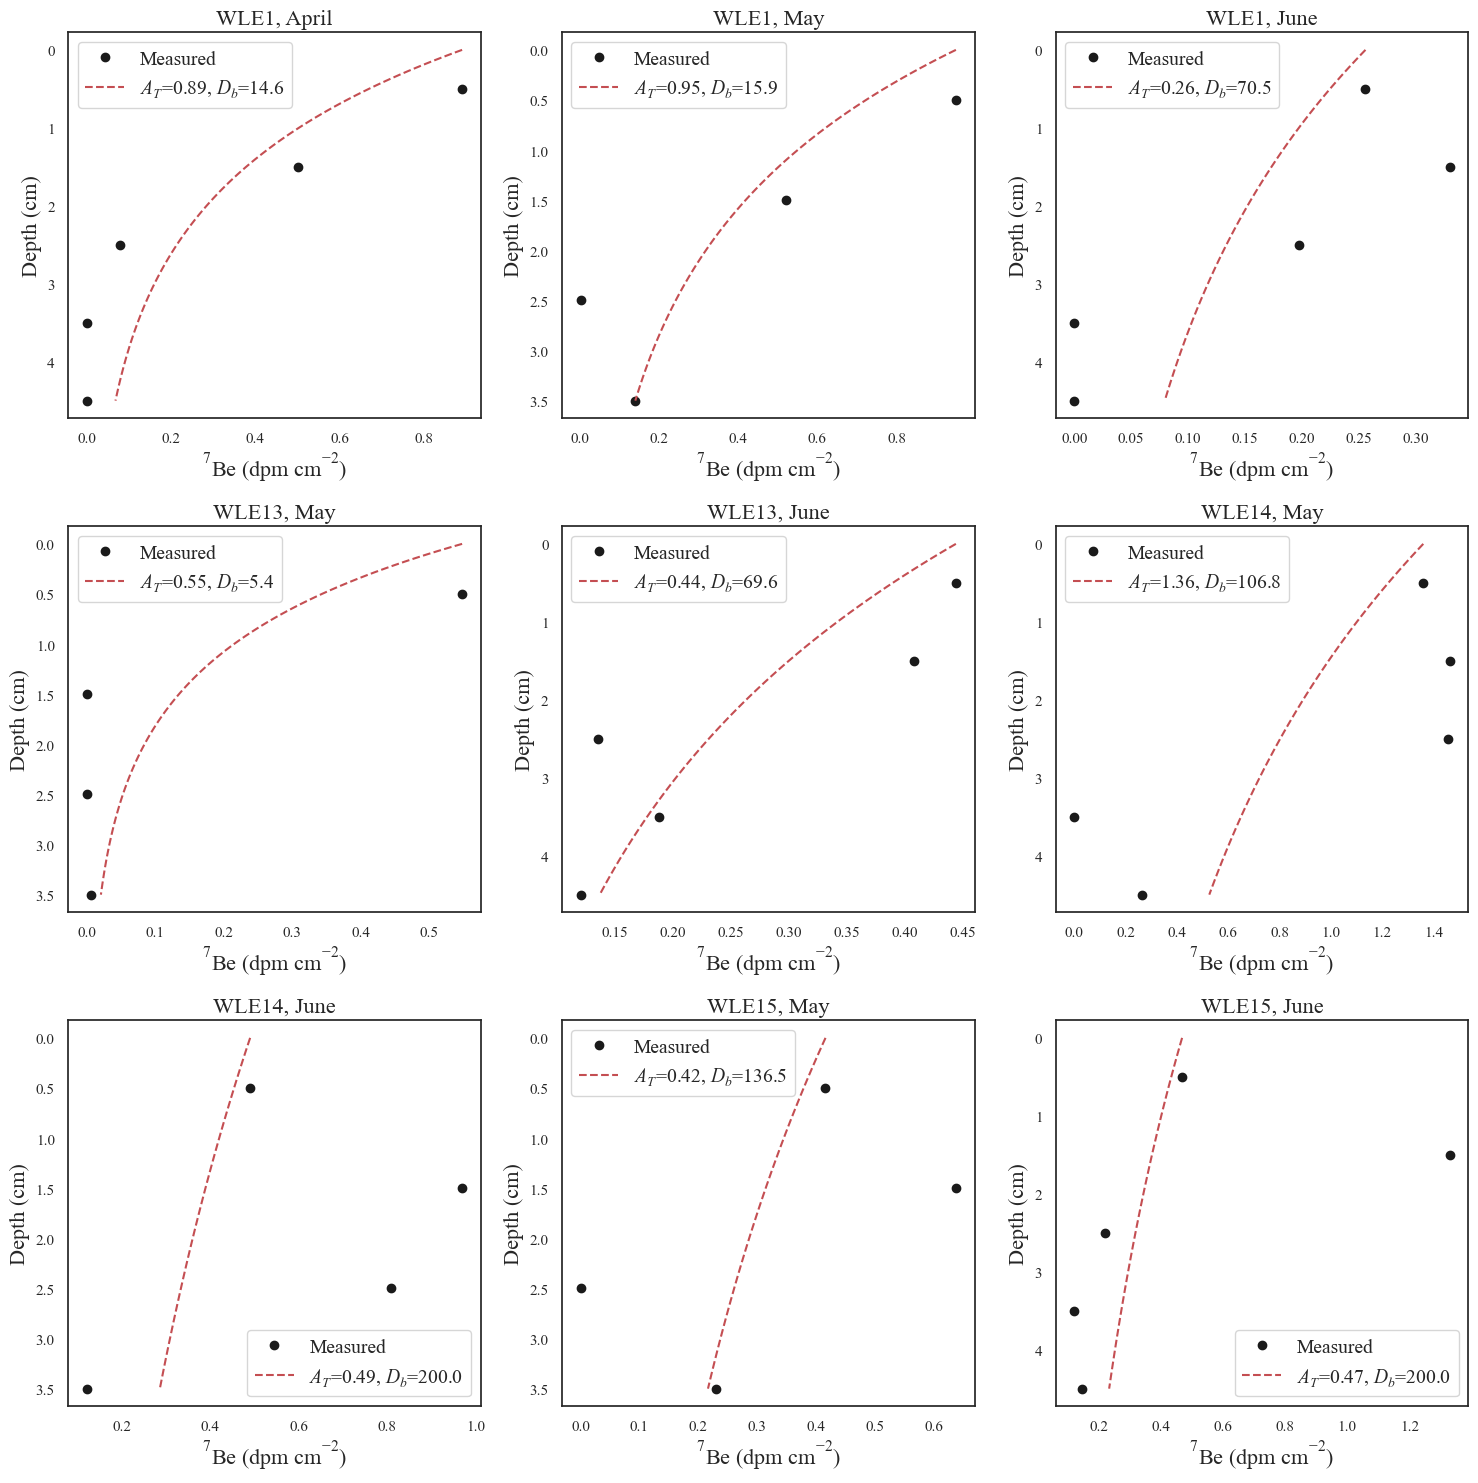

In [49]:
month_order = ["April", "May", "June"]

# --- Capture the returned figure from function ---
fig = plot_be7_profiles_with_fits(
    be_2023,
    results_df=db_2023,
    month_order=month_order
)

# --- Define save path ---
plt.savefig(os.path.join(fig_dir, "F_db_2023.png"), dpi=500, bbox_inches='tight')
plt.show()

### Supplementary Figure 2b

/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3383016021.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(group_cols)


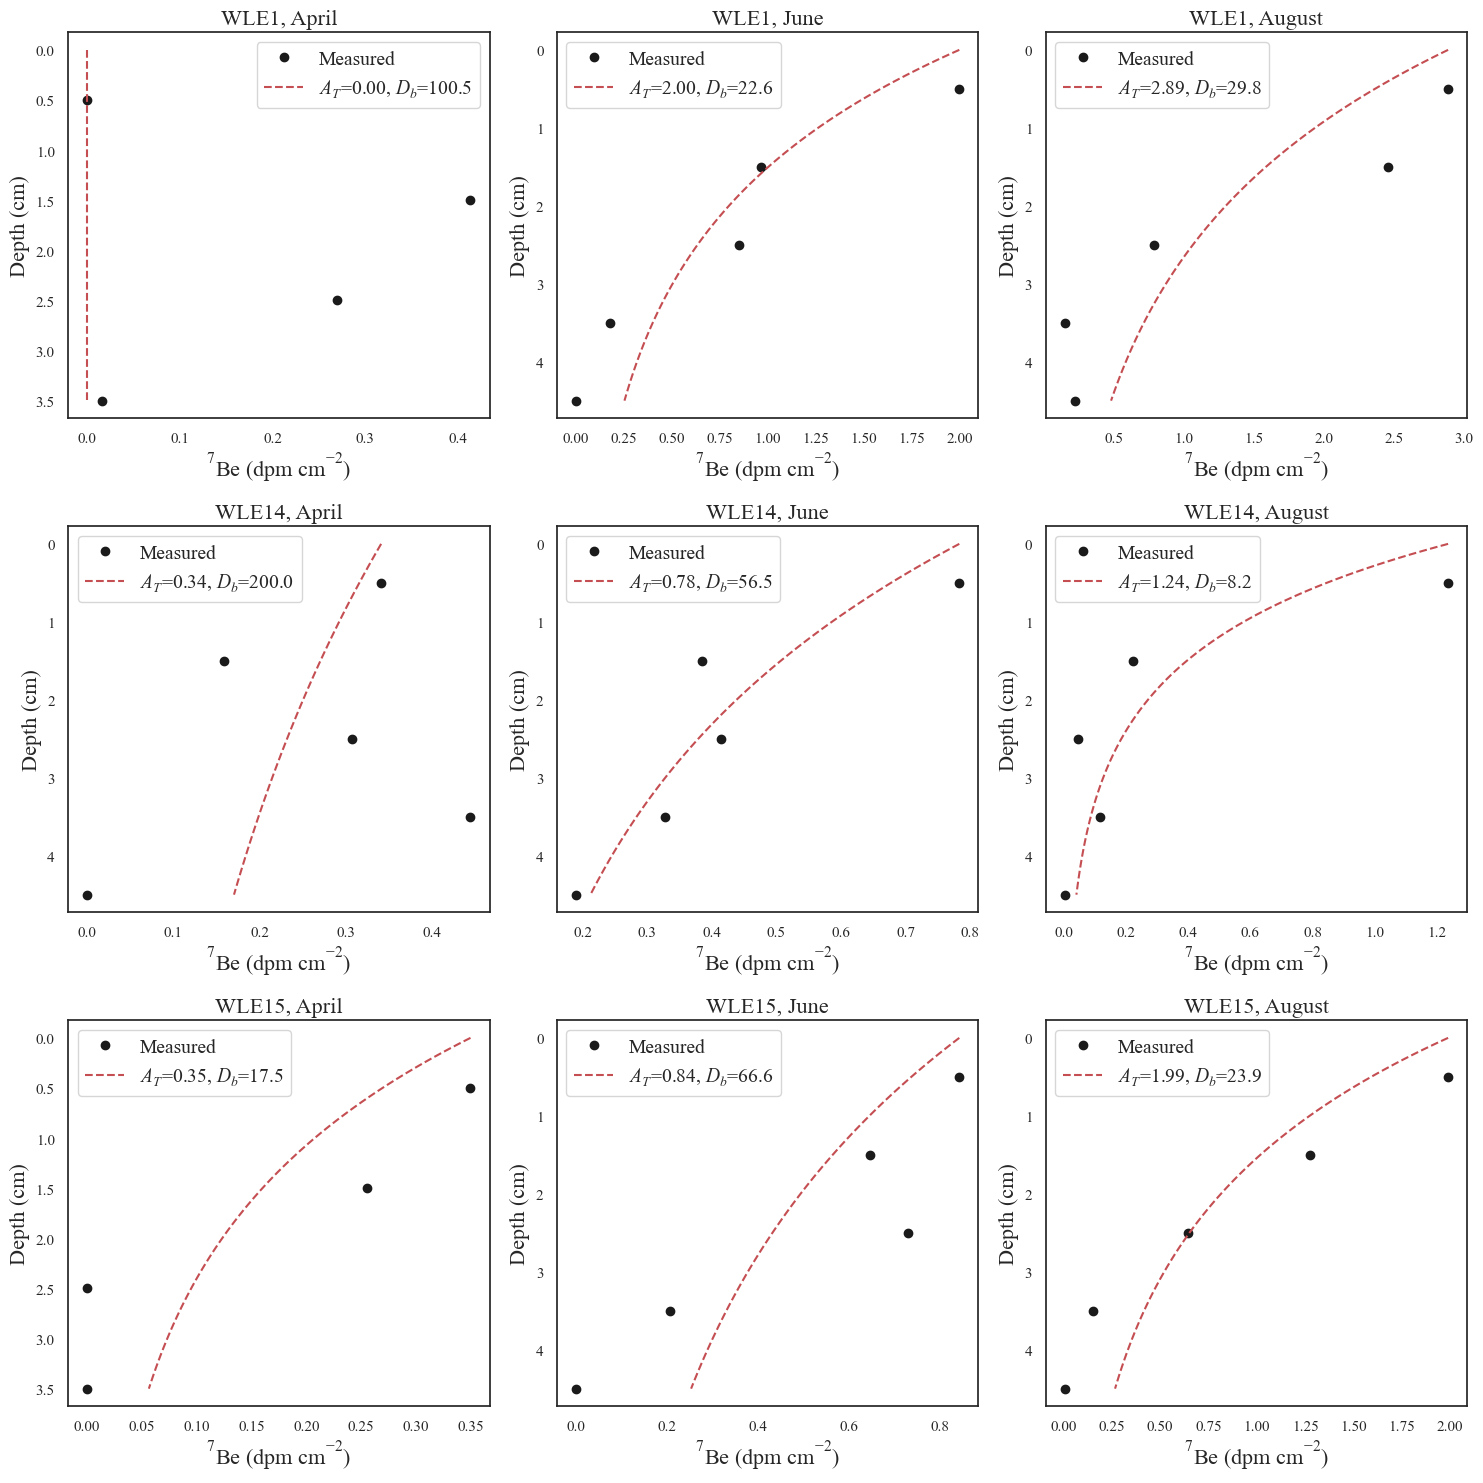

In [50]:
month_order = ["April", "June", "August"]

# --- Capture the returned figure from function ---
fig = plot_be7_profiles_with_fits(
    be_2024,
    results_df=db_2024,
    month_order=month_order
)

# --- Define save path ---
plt.savefig(os.path.join(fig_dir, "F_db_2024.png"), dpi=500, bbox_inches='tight')
plt.show()


## Supplementary Figure 3a and 3b: Temporal change of measured ⁷Be inventories and reference decay curves.

/var/folders/tb/sn9xqkx911lftlglmn_2kc6w0000gn/T/ipykernel_24388/3763865882.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_inventories = be_2024.groupby(['station', 'month'])['Be-7(dpm/cm3)'].sum().reset_index()


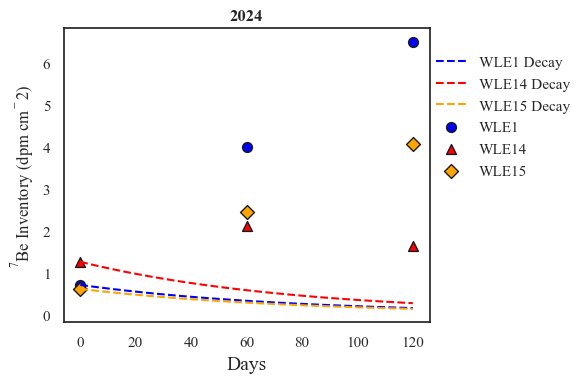

In [51]:
# ---------- Global Font style ----------
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

"To reproduce results for another year, change the year variable in the script." 
"All figures and outputs will automatically update."

# Compute the decay constant (λ) for ⁷Be from its 53.3-day half-life.
half_life_be7 = 53.3  # days
lambda_be7 = np.log(2) / half_life_be7

# Calculate total Be-7 inventories by summing Be-7(dpm/cm3)
total_inventories = be_2024.groupby(['station', 'month'])['Be-7(dpm/cm3)'].sum().reset_index()

# Assign approximate sampling days for plotting
month_days = {'April': 0, 'May': 30, 'June': 60, 'August': 120}
total_inventories['Day'] = total_inventories['month'].map(month_days)

# Extract earliest available inventories for each station (not necessarily April)
initial_inventories = {}
initial_days = {}
for station in total_inventories['station'].unique():
    station_data = total_inventories[total_inventories['station'] == station].sort_values('Day')
    earliest_data = station_data.iloc[0]
    initial_inventories[station] = earliest_data['Be-7(dpm/cm3)']
    initial_days[station] = earliest_data['Day']

# Plot setup
plt.figure(figsize=(6, 4))

# Define colors and markers
colors_markers = {
    'WLE1': ('blue', 'o'),
    'WLE13': ('green', 's'),
    'WLE14': ('red', '^'),
    'WLE15': ('orange', 'D')
}

# Plot decay curves starting from earliest available month per station
for station, initial_inventory in initial_inventories.items():
    start_day = initial_days[station]
    plot_days = np.arange(start_day, 121, 1)
    decay_curve = initial_inventory * np.exp(-lambda_be7 * (plot_days - start_day))
    plt.plot(plot_days, decay_curve, linestyle='--', color=colors_markers[station][0], label=f'{station} Decay')

# Plot observed inventory points
for idx, row in total_inventories.iterrows():
    plt.scatter(row['Day'], row['Be-7(dpm/cm3)'], 
                color=colors_markers[row['station']][0],
                marker=colors_markers[row['station']][1], s=50, edgecolor='k',
                label=f'{row["station"]}' if f'{row["station"]}' not in plt.gca().get_legend_handles_labels()[1] else "")

# Formatting plot
plt.xlabel('Days', fontsize=14)
plt.ylabel('$^7$Be Inventory (dpm cm$^-2$)', fontsize=12)
plt.title('2024', fontsize=12, fontweight = 'bold')
# plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(
    bbox_to_anchor=(0.98, 0.7),   # (x, y) position — move right of plot
    loc='center left',            # align legend to left side of box
    frameon=False,                # optional: remove border
    fontsize=11
)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "decay_2024.png"), dpi=500, bbox_inches='tight')
plt.show()

## Supplementary Figure 4: Linear fit of chlorophyll and total phosphorus (TP) versus suspended particulate matter (SPM

In [52]:
combined_df = pd.read_csv(WATER_DIR / 'spm_tp_srp_chl.csv', parse_dates=['date'])
data_without_mr1_2024 = combined_df[~((combined_df['station'] == 'MR1') & (combined_df['year'] == 2024))]


In [53]:
df_2023 = data_without_mr1_2024[data_without_mr1_2024['year'] == 2023]
df_2024 = data_without_mr1_2024[data_without_mr1_2024['year'] == 2024]
exclude_dates = [20230526]  # Resuspension dates
df_2023_fit = df_2023[~df_2023['date'].isin(exclude_dates)]
df_2023_excluded = df_2023[df_2023['date'].isin(exclude_dates)]

### Supplementary Figure S4a: SPM vs TP

In [54]:
def compute_confidence_band(X, y_true, model, alpha=0.01):
    """Compute the confidence interval for linear regression predictions."""
    y_pred = model.predict(X)
    n = X.shape[0]
    p = X.shape[1]
    dof = n - p - 1
    t_value = stats.t.ppf(1 - alpha / 2, dof)

    residuals = y_true - y_pred
    s_err = np.sqrt(np.sum(residuals**2) / dof)

    mean_x = np.mean(X)
    se_fit = s_err * np.sqrt(1/n + (X - mean_x)**2 / np.sum((X - mean_x)**2))

    ci = t_value * se_fit.flatten()
    y_upper = y_pred + ci
    y_lower = y_pred - ci
    return y_lower, y_upper

def plot_and_evaluate_chl_tp(data, filename, title):
    """Plot scatter points and linear regression for total phosphorus (TP) vs SPM (or any chosen variable),
    including 2023, 2024, and combined data. Computes metrics and confidence intervals."""
    # Set blue shades
    color_2023 = 'red'     # standard blue
    color_2024 = 'blue'     # slightly lighter blue
    color_combined = 'green' # soft blue-lavender for combined

    alpha_markers = 0.4
    alpha_lines = 0.8

    # Split data
    df_2023 = data[data['year'] == 2023]
    df_2024 = data[data['year'] == 2024]
    exclude_dates = ['20230526']  # Resuspension date
    df_2023_fit = df_2023[~df_2023['date'].isin(exclude_dates)]
    df_2023_excluded = df_2023[df_2023['date'].isin(exclude_dates)]

    # Extract values
    X_2023 = df_2023_fit[['total_spm_g_per_m3']].astype(float).values
    y_2023 = df_2023_fit['tp_mg_per_ml'].astype(float).values

    X_2024 = df_2024[['total_spm_g_per_m3']].astype(float).values
    y_2024 = df_2024['tp_mg_per_ml'].astype(float).values

    df_all = pd.concat([df_2023_fit, df_2024], ignore_index=True)
    X_all = df_all[['total_spm_g_per_m3']].astype(float).values
    y_all = df_all['tp_mg_per_ml'].astype(float).values

    # Fit regressions
    model_2023 = LinearRegression().fit(X_2023, y_2023)
    model_2024 = LinearRegression().fit(X_2024, y_2024)
    model_all = LinearRegression().fit(X_all, y_all)

    y_pred_2023 = model_2023.predict(X_2023)
    y_pred_2024 = model_2024.predict(X_2024)
    y_pred_all = model_all.predict(X_all)

    y_2023_lower, y_2023_upper = compute_confidence_band(X_2023, y_2023, model_2023)
    y_2024_lower, y_2024_upper = compute_confidence_band(X_2024, y_2024, model_2024)
    y_all_lower, y_all_upper = compute_confidence_band(X_all, y_all, model_all)

    sorted_2023 = np.argsort(X_2023.flatten())
    sorted_2024 = np.argsort(X_2024.flatten())
    sorted_all = np.argsort(X_all.flatten())

    def calculate_metrics(y_true, y_pred, X):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        n = len(y_true)
        p = X.shape[1]
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        bias = np.mean(y_pred - y_true)
        return rmse, r2, adjusted_r2, mape, bias, n

    metrics_2023 = calculate_metrics(y_2023, y_pred_2023, X_2023)
    metrics_2024 = calculate_metrics(y_2024, y_pred_2024, X_2024)
    metrics_all = calculate_metrics(y_all, y_pred_all, X_all)

    # Plot setup
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots(figsize=(6, 4))

    # Scatter plots
    sns.scatterplot(x='total_spm_g_per_m3', y='tp_mg_per_ml', data=df_2023_fit,
                    color=color_2023, label=f'2023 (n={metrics_2023[5]})', s=35, alpha=alpha_markers, ax=ax)

    sns.scatterplot(x='total_spm_g_per_m3', y='tp_mg_per_ml', data=df_2024,
                    color=color_2024, label=f'2024 (n={metrics_2024[5]})', s=35, alpha=alpha_markers, ax=ax)

    sns.scatterplot(x='total_spm_g_per_m3', y='tp_mg_per_ml', data=df_2023_excluded,
                    color='red', marker='X', s=60, label='Resuspension point', ax=ax)

    # Regression lines
    ax.plot(X_2023, y_pred_2023, color=color_2023, linestyle='solid', label=f'2023 Fit (R²={metrics_2023[1]:.2f})', alpha=alpha_lines, linewidth = 0.5)
    ax.plot(X_2024, y_pred_2024, color=color_2024, linestyle='solid', label=f'2024 Fit (R²={metrics_2024[1]:.2f})', alpha=alpha_lines, linewidth = 0.5)
    ax.plot(X_all, y_pred_all, color=color_combined, linestyle='solid', label=f'Combined Fit (R²={metrics_all[1]:.2f})', alpha=alpha_lines, linewidth = 0.5)

    # Confidence intervals
    ax.fill_between(X_2023.flatten()[sorted_2023], y_2023_lower[sorted_2023], y_2023_upper[sorted_2023], color=color_2023, alpha=0.1, linewidth = 0.5)
    ax.fill_between(X_2024.flatten()[sorted_2024], y_2024_lower[sorted_2024], y_2024_upper[sorted_2024], color=color_2024, alpha=0.1, linewidth = 0.5)
    ax.fill_between(X_all.flatten()[sorted_all], y_all_lower[sorted_all], y_all_upper[sorted_all], color=color_combined, alpha=0.1, linewidth = 0.5)

    # Labels and legend
    ax.set_xlabel('SPM (g m$^{-3}$)', fontweight='bold')
    ax.set_ylabel('TP (mg L$^{-1}$)', fontweight='bold')
    ax.set_title(title, fontweight='bold')

    # Anchor legend outside
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, frameon=False)

    # Save and show
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, filename), dpi=500, bbox_inches='tight')
    plt.show()

    # Print metrics
    print(f"\nMetrics for 2023:\nRMSE: {metrics_2023[0]:.3f}, R²: {metrics_2023[1]:.3f}, Adjusted R²: {metrics_2023[2]:.3f}, MAPE: {metrics_2023[3]:.3f}, Bias: {metrics_2023[4]:.3f}, n={metrics_2023[5]}")
    print(f"Metrics for 2024:\nRMSE: {metrics_2024[0]:.3f}, R²: {metrics_2024[1]:.3f}, Adjusted R²: {metrics_2024[2]:.3f}, MAPE: {metrics_2024[3]:.3f}, Bias: {metrics_2024[4]:.3f}, n={metrics_2024[5]}")
    print(f"Metrics for Combined:\nRMSE: {metrics_all[0]:.3f}, R²: {metrics_all[1]:.3f}, Adjusted R²: {metrics_all[2]:.3f}, MAPE: {metrics_all[3]:.3f}, Bias: {metrics_all[4]:.3f}, n={metrics_all[5]}")


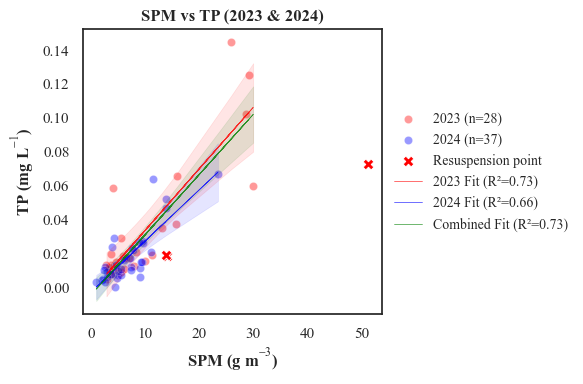


Metrics for 2023:
RMSE: 0.018, R²: 0.734, Adjusted R²: 0.724, MAPE: 0.433, Bias: 0.000, n=28
Metrics for 2024:
RMSE: 0.009, R²: 0.660, Adjusted R²: 0.650, MAPE: 1298622641988.722, Bias: 0.000, n=37
Metrics for Combined:
RMSE: 0.014, R²: 0.728, Adjusted R²: 0.724, MAPE: 788884879717.998, Bias: -0.000, n=65


In [55]:
c_data_without_mr1_2024 = data_without_mr1_2024.dropna(subset=['total_spm_g_per_m3', 'tp_mg_per_ml'])
plot_and_evaluate_chl_tp(c_data_without_mr1_2024, 'tp_vs_spm', 'SPM vs TP (2023 & 2024)')

### Supplementary Figure S4b: SPM vs Chla

In [56]:
def compute_confidence_band(X, y_true, model, alpha=0.01):
    """Compute the confidence interval for linear regression predictions."""
    # Ensure 2D
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Drop any NaNs just in case
    mask = ~np.isnan(X.flatten()) & ~np.isnan(y_true)
    X = X[mask]
    X = X.reshape(-1, 1)
    y_true = y_true[mask]

    y_pred = model.predict(X)
    n = X.shape[0]
    p = X.shape[1]
    dof = n - p - 1

    if dof <= 0:
        # Not enough data for a proper CI
        return y_pred, y_pred

    t_value = stats.t.ppf(1 - alpha / 2, dof)

    residuals = y_true - y_pred
    s_err = np.sqrt(np.sum(residuals**2) / dof)

    mean_x = np.mean(X)
    se_fit = s_err * np.sqrt(1/n + (X - mean_x)**2 / np.sum((X - mean_x)**2))

    ci = t_value * se_fit.flatten()
    y_upper = y_pred + ci
    y_lower = y_pred - ci
    return y_lower, y_upper


def plot_and_evaluate_chl(data, filename, title):
    """
    Plot scatter points and linear regression for chlorophyll (Chl) vs SPM,
    including 2023, 2024, and combined data. Computes metrics and confidence intervals.
    """

    # Colors
    color_2023 = 'red'
    color_2024 = 'blue'
    color_combined = 'green'

    alpha_markers = 0.4
    alpha_lines = 0.8

    # -----------------------------
    # Split data and drop NaNs
    # -----------------------------
    df_2023 = data[data['year'] == 2023].copy()
    df_2024 = data[data['year'] == 2024].copy()

    df_2023 = df_2023.dropna(subset=['total_spm_g_per_m3', 'chla_rfu'])
    df_2024 = df_2024.dropna(subset=['total_spm_g_per_m3', 'chla_rfu'])

    # Exclude resuspension date from 2023 fit
    exclude_dates = ['20230526']  # match type to date column (string vs int)
    df_2023_fit = df_2023[~df_2023['date'].isin(exclude_dates)].copy()
    df_2023_excluded = df_2023[df_2023['date'].isin(exclude_dates)].copy()

    # Combined dataset
    df_all = pd.concat([df_2023_fit, df_2024], ignore_index=True)
    df_all = df_all.dropna(subset=['total_spm_g_per_m3', 'chla_rfu'])

    # -----------------------------
    # Extract values
    # -----------------------------
    X_2023 = df_2023_fit[['total_spm_g_per_m3']].astype(float).values
    y_2023 = df_2023_fit['chla_rfu'].astype(float).values

    X_2024 = df_2024[['total_spm_g_per_m3']].astype(float).values
    y_2024 = df_2024['chla_rfu'].astype(float).values

    X_all = df_all[['total_spm_g_per_m3']].astype(float).values
    y_all = df_all['chla_rfu'].astype(float).values

    # -----------------------------
    # Fit regressions
    # -----------------------------
    model_2023 = LinearRegression().fit(X_2023, y_2023)
    model_2024 = LinearRegression().fit(X_2024, y_2024)
    model_all = LinearRegression().fit(X_all, y_all)

    y_pred_2023 = model_2023.predict(X_2023)
    y_pred_2024 = model_2024.predict(X_2024)
    y_pred_all = model_all.predict(X_all)

    # -----------------------------
    # Confidence intervals
    # -----------------------------
    y_2023_lower, y_2023_upper = compute_confidence_band(X_2023, y_2023, model_2023)
    y_2024_lower, y_2024_upper = compute_confidence_band(X_2024, y_2024, model_2024)
    y_all_lower, y_all_upper = compute_confidence_band(X_all, y_all, model_all)

    sorted_2023 = np.argsort(X_2023.flatten())
    sorted_2024 = np.argsort(X_2024.flatten())
    sorted_all = np.argsort(X_all.flatten())

    # -----------------------------
    # Metrics
    # -----------------------------
    def calculate_metrics(y_true, y_pred, X):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        n = len(y_true)
        p = X.shape[1]
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        bias = np.mean(y_pred - y_true)
        return rmse, r2, adjusted_r2, mape, bias, n

    metrics_2023 = calculate_metrics(y_2023, y_pred_2023, X_2023)
    metrics_2024 = calculate_metrics(y_2024, y_pred_2024, X_2024)
    metrics_all = calculate_metrics(y_all, y_pred_all, X_all)

    # -----------------------------
    # Plot setup
    # -----------------------------
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots(figsize=(6, 4))

    # Scatter plots
    sns.scatterplot(
        x='total_spm_g_per_m3', y='chla_rfu', data=df_2023_fit,
        color=color_2023, label=f'2023 (n={metrics_2023[5]})',
        s=35, alpha=alpha_markers, ax=ax
    )

    sns.scatterplot(
        x='total_spm_g_per_m3', y='chla_rfu', data=df_2024,
        color=color_2024, label=f'2024 (n={metrics_2024[5]})',
        s=35, alpha=alpha_markers, ax=ax
    )

    sns.scatterplot(
        x='total_spm_g_per_m3', y='chla_rfu', data=df_2023_excluded,
        color='red', marker='X', s=60, label='Resuspension point', ax=ax
    )

    # Regression lines
    ax.plot(
        X_2023, y_pred_2023,
        color=color_2023, linestyle='solid',
        label=f'2023 Fit (R²={metrics_2023[1]:.2f})',
        alpha=alpha_lines, linewidth=0.5
    )
    ax.plot(
        X_2024, y_pred_2024,
        color=color_2024, linestyle='solid',
        label=f'2024 Fit (R²={metrics_2024[1]:.2f})',
        alpha=alpha_lines, linewidth=0.5
    )
    ax.plot(
        X_all, y_pred_all,
        color=color_combined, linestyle='solid',
        label=f'Combined Fit (R²={metrics_all[1]:.2f})',
        alpha=alpha_lines, linewidth=0.5
    )

    # Confidence intervals
    ax.fill_between(
        X_2023.flatten()[sorted_2023],
        y_2023_lower[sorted_2023],
        y_2023_upper[sorted_2023],
        color=color_2023, alpha=0.1, linewidth=0.5
    )
    ax.fill_between(
        X_2024.flatten()[sorted_2024],
        y_2024_lower[sorted_2024],
        y_2024_upper[sorted_2024],
        color=color_2024, alpha=0.1, linewidth=0.5
    )
    ax.fill_between(
        X_all.flatten()[sorted_all],
        y_all_lower[sorted_all],
        y_all_upper[sorted_all],
        color=color_combined, alpha=0.1, linewidth=0.5
    )

    # Labels and legend
    ax.set_xlabel('SPM (g m$^{-3}$)', fontweight='bold')
    ax.set_ylabel('Chl (rfu)', fontweight='bold')
    ax.set_title(title, fontweight='bold')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, frameon=False)

    # Save and show
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, filename), dpi=500, bbox_inches='tight')
    plt.show()

    # Print metrics
    print(f"\nMetrics for 2023:\nRMSE: {metrics_2023[0]:.3f}, R²: {metrics_2023[1]:.3f}, "
          f"Adjusted R²: {metrics_2023[2]:.3f}, MAPE: {metrics_2023[3]:.3f}, "
          f"Bias: {metrics_2023[4]:.3f}, n={metrics_2023[5]}")
    print(f"\nMetrics for 2024:\nRMSE: {metrics_2024[0]:.3f}, R²: {metrics_2024[1]:.3f}, "
          f"Adjusted R²: {metrics_2024[2]:.3f}, MAPE: {metrics_2024[3]:.3f}, "
          f"Bias: {metrics_2024[4]:.3f}, n={metrics_2024[5]}")
    print(f"\nMetrics for Combined:\nRMSE: {metrics_all[0]:.3f}, R²: {metrics_all[1]:.3f}, "
          f"Adjusted R²: {metrics_all[2]:.3f}, MAPE: {metrics_all[3]:.3f}, "
          f"Bias: {metrics_all[4]:.3f}, n={metrics_all[5]}")

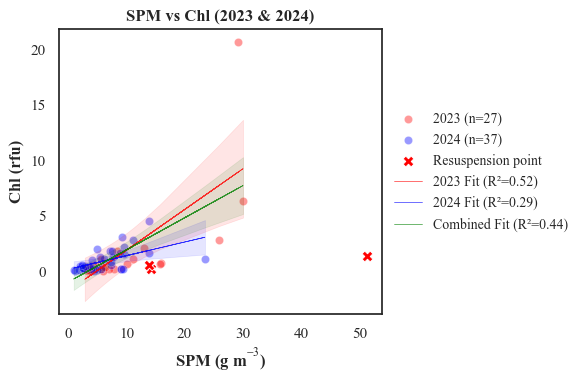


Metrics for 2023:
RMSE: 2.740, R²: 0.519, Adjusted R²: 0.499, MAPE: 2.636, Bias: -0.000, n=27

Metrics for 2024:
RMSE: 0.837, R²: 0.294, Adjusted R²: 0.274, MAPE: 1.439, Bias: -0.000, n=37

Metrics for Combined:
RMSE: 2.010, R²: 0.442, Adjusted R²: 0.433, MAPE: 1.836, Bias: -0.000, n=64


In [57]:
c_data_without_mr1_2024 = data_without_mr1_2024.dropna(subset=['total_spm_g_per_m3', 'chla_rfu'])
plot_and_evaluate_chl(c_data_without_mr1_2024, 'spm_vs_chl', 'SPM vs Chl (2023 & 2024)')

## Supplementary Figure 5: Validation of SPM algorithm

In [58]:
spmdata = pd.read_csv(WATER_DIR / 'spm_svc_2023_24_nechad_Xoutliers_AVERAGED.csv')
spmdata.columns


Index(['Date', 'Station', 'Avg_665', 'Std_665', 'insitu_spm', 'rep_avg'], dtype='object')

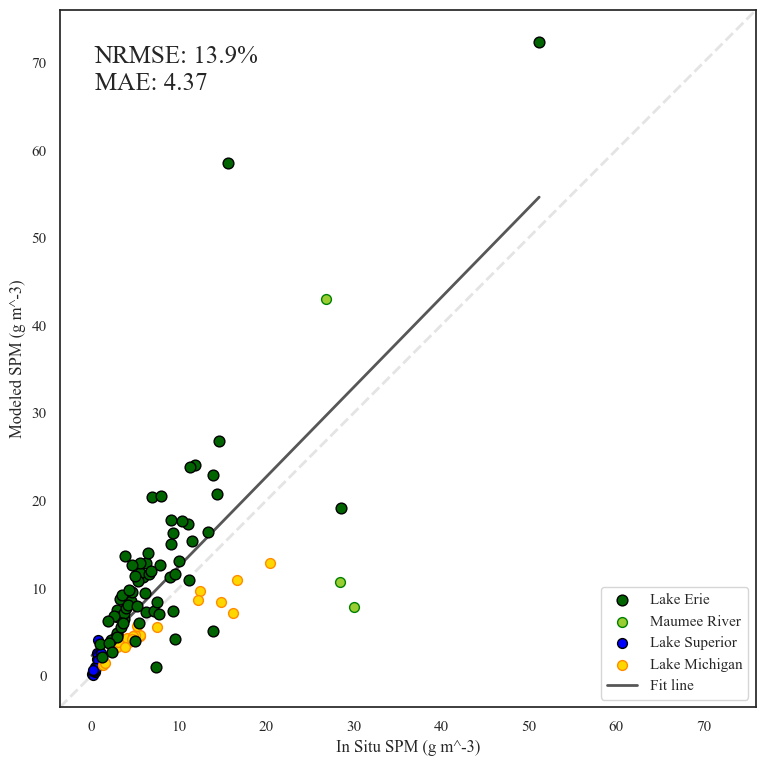

In [59]:


#Data extraction
x = spmdata['insitu_spm']
svc665 = spmdata['rep_avg']


#Algorithm functionality
#
#Variables and Algorithm Parameters
pi = np.pi
R = 1
Ap = 355.85
Bp = 0
Cp = 0.1728

#Nechad algorithm application
nechad_665 = (Ap * pi * svc665) / (1 - ((svc665 * pi) / Cp)) + Bp

#Defining funcs below

#RMSE/NRMSE func
def calculate_rmse(actual_values, predicted_values):
    mse = mean_squared_error(actual_values, predicted_values)
    return np.sqrt(mse)

#MAE func
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

#RMSE, NRMSE, MAE calculations
rmse_value = calculate_rmse(x, nechad_665)
nrmse_value = (rmse_value / (x.max() - x.min())) * 100
mae = mean_absolute_error(x, nechad_665)


#Plotting parameters
#
#Coloring func
def get_station_color(station):
    if station.startswith("WLE"):
        return 'darkgreen'
    elif station.startswith("DR"):
        return 'darkgreen'
    elif station.startswith("MR"):
        return 'yellowgreen'
    elif station.startswith("WARM"):
        return 'blue'
    elif station.startswith("KBAY"):
        return 'blue'
    elif station.startswith("KEW"):
        return 'blue'
    elif station.startswith("GB"):
        return 'gold'
    elif station.startswith("CLE"):
        return 'green'
    elif station.startswith("PIB"):
        return 'green'
    else:
        return 'grey'

#Color mapping
spmdata['Color'] = spmdata['Station'].apply(get_station_color)
plt.figure(figsize=(8, 8))
#Seaborn style for a cleaner look and updated font sizes
sns.set_style("white")
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family'] = 'Times New Roman'
 
#Dynamic axis limits
min_val = min(x.min(), nechad_665.min())
max_val = max(x.max(), nechad_665.max())
buffer = (max_val - min_val) * 0.05
axis_min = min_val - buffer
axis_max = max_val + buffer
 
#1:1 reference line plotting
plt.plot([axis_min, axis_max], [axis_min, axis_max], 
         color='darkgrey', linestyle='--', linewidth=2, alpha=0.314)
 
#Calculate and plot the trendline (sorting x for a smoother line)
sorted_indices = np.argsort(x)
sorted_x = x.iloc[sorted_indices]
trend_coeffs = np.polyfit(x, nechad_665, 1)
sorted_trend = np.polyval(trend_coeffs, sorted_x)
 
 
# ~ ~ ~ ~ ~ ~ ~ ~ ~ Plot Order ~ ~ ~ ~ ~ ~ ~ ~ ~
#Create the scatter plot in two layers, for ordering
 
#Erie Sites
mask_darkgreen = spmdata['Color'] == 'darkgreen'
plt.scatter(x[mask_darkgreen], nechad_665[mask_darkgreen],
            label="Lake Erie", color='darkgreen', s=60, edgecolor='black', zorder=3)
#Maumee Site
mask_yellowgreen = spmdata['Color'] == 'yellowgreen'
plt.scatter(x[mask_yellowgreen], nechad_665[mask_yellowgreen], color='yellowgreen', s=50, zorder=2,
            label = "Maumee River", edgecolor = 'green')
#Superior Sites
mask_blue = spmdata['Color'] == 'blue'
plt.scatter(x[mask_blue], nechad_665[mask_blue], color='blue', s=50, zorder=2,
            label = "Lake Superior", edgecolor = 'black')
 
#GreenBay Sites
mask_gold = spmdata['Color'] == 'gold'
plt.scatter(x[mask_gold], nechad_665[mask_gold], color='gold', s=50, zorder=2,
            label = "Lake Michigan", edgecolor = 'darkorange')
 
 
plt.plot(sorted_x, sorted_trend, label="Fit line", color='black', 
         linestyle='-', linewidth=2, alpha = 0.66)
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
#Titles and labels
plt.title('')
plt.xlabel('In Situ SPM (g m^-3)')
plt.ylabel('Modeled SPM (g m^-3)')
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)
 
#Statistics textbox
stats_text = f"NRMSE: {nrmse_value:.1f}%\nMAE: {mae:.2f}"
plt.gca().text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
               fontsize=18, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#PLOT!
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "spm_algorithm_validation.png"), dpi=500, bbox_inches='tight')
plt.show()

# One-ANOVA analysis for vertical, spatial and monthly varibility in phoshorus fraction concentration

### Supplementary Table 4: One-way ANOVA for variations of P fraction concentrations across depths (0-5 cm)

In [60]:
def run_one_factor_anova_by_depth(df, fractions, depth_col="Depth"):
    """
    Performs one-factor ANOVA for each fraction across depth categories.
    """
    df = df.copy()
    df[depth_col] = df[depth_col].astype(str)
    results = []

    # Total sample size for each ANOVA = number of rows used
    N = len(df)

    for frac in fractions:
        try:
            model = ols(f"{frac} ~ C({depth_col})", data=df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)

            # Extract row for the depth factor
            row = anova_table.loc[f"C({depth_col})"]

            results.append({
                "Fraction": frac,
                "F-statistic": row["F"],
                "p-value": row["PR(>F)"],
                "df_between": row["df"],                   # numerator df
                "df_within": anova_table.loc["Residual"]["df"],  # denominator df
                "N": N                                      # total sample size
            })
        except Exception:
            results.append({
                "Fraction": frac,
                "F-statistic": None,
                "p-value": None,
                "df_between": None,
                "df_within": None,
                "N": N
            })

    return pd.DataFrame(results)

In [61]:
fractions = ["NaCl", "NaBD", "NaOH", "HCl", "RP", "TP"]
depth_anova_df = run_one_factor_anova_by_depth(p_data, fractions)
print(depth_anova_df)

  Fraction  F-statistic   p-value  df_between  df_within   N
0     NaCl     0.577060  0.680905         4.0       40.0  45
1     NaBD     0.338780  0.850127         4.0       39.0  45
2     NaOH     0.229863  0.920006         4.0       40.0  45
3      HCl     0.186594  0.944023         4.0       40.0  45
4       RP     0.864314  0.493673         4.0       40.0  45
5       TP     0.609883  0.657894         4.0       40.0  45


### One-way ANOVA for variations of P fraction  across stations

In [62]:
def run_anova_by_station(df, fractions, station_col="Station"):
    """
    Perform one-way ANOVA for each fraction across stations.
    
    """
    # Ensure station column is string type
    df[station_col] = df[station_col].astype(str)
    
    results = []

    for frac in fractions:
        try:
            # Fit the model: fraction ~ stations
            model = ols(f"{frac} ~ C({station_col})", data=df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)

            # Extract the row corresponding to the station effect
            row = anova_table.loc[f"C({station_col})"]

            # Append results
            results.append({
                "Fraction": frac,
                "F-statistic": row["F"],
                "p-value": row["PR(>F)"]
            })
        except Exception as e:
            # If there is an error (e.g., insufficient data), append None
            results.append({
                "Fraction": frac,
                "F-statistic": None,
                "p-value": None
            })

    return pd.DataFrame(results)

In [63]:
fractions = ["NaCl", "NaBD", "NaOH", "HCl", "RP", "TP"]
station_anova_df = run_anova_by_station(p_data, fractions)
print(station_anova_df)

  Fraction  F-statistic       p-value
0     NaCl    50.231739  8.613002e-14
1     NaBD    16.395527  4.218390e-07
2     NaOH     3.011655  4.089484e-02
3      HCl    14.780001  1.138867e-06
4       RP    12.696145  5.232901e-06
5       TP     8.319506  1.940397e-04


In [64]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Prepare data
valid_data = p_data[["NaCl", "Station"]].dropna()

# Tukey HSD test
tukey_result = pairwise_tukeyhsd(
    endog=valid_data["NaCl"],
    groups=valid_data["Station"],
    alpha=0.02
)

# Show results
print(tukey_result.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.02 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  WLE1  WLE13   -0.002 0.9371 -0.0125  0.0085  False
  WLE1  WLE14  -0.0313    0.0 -0.0418 -0.0208   True
  WLE1  WLE15  -0.0322    0.0 -0.0427 -0.0218   True
 WLE13  WLE14  -0.0293    0.0 -0.0408 -0.0178   True
 WLE13  WLE15  -0.0302    0.0 -0.0417 -0.0188   True
 WLE14  WLE15  -0.0009 0.9948 -0.0124  0.0106  False
----------------------------------------------------


## One-way ANOVA per month, testing whether station means differ for each fraction (analysis for the main manuscript)

In [65]:
def run_anova_by_station_per_month(df, fractions, month_col="Month", station_col="Station"):
    """
    One-way ANOVA per month, testing whether station means differ
    for each fraction.

    For each Month × Fraction:
        frac ~ C(Station)
    """
    df[month_col] = df[month_col].astype(str)
    df[station_col] = df[station_col].astype(str)
    
    results = []

    for month in df[month_col].unique():
        for frac in fractions:
            try:
                # Drop rows where the target fraction or station is missing
                month_df = df[df[month_col] == month][[station_col, frac]].dropna()

                if month_df[station_col].nunique() > 1:
                    model = ols(f"{frac} ~ C({station_col})", data=month_df).fit()
                    anova_table = sm.stats.anova_lm(model, typ=2)
                    row = anova_table.loc[f"C({station_col})"]
                    results.append({
                        "Month": month,
                        "Fraction": frac,
                        "F-statistic": row["F"],
                        "p-value": row["PR(>F)"]
                    })
                else:
                    results.append({
                        "Month": month,
                        "Fraction": frac,
                        "F-statistic": None,
                        "p-value": None
                    })

            except:
                results.append({
                    "Month": month,
                    "Fraction": frac,
                    "F-statistic": None,
                    "p-value": None
                })

    return pd.DataFrame(results)

In [66]:
fractions = ["NaCl", "NaBD", "NaOH", "HCl", "RP", "TP"]
anova_station_by_month = station_anova_df = run_anova_by_station_per_month(p_data, fractions)
print(anova_station_by_month)

    Month Fraction  F-statistic       p-value
0   April     NaCl          NaN           NaN
1   April     NaBD          NaN           NaN
2   April     NaOH          NaN           NaN
3   April      HCl          NaN           NaN
4   April       RP          NaN           NaN
5   April       TP          NaN           NaN
6     May     NaCl    99.793271  1.431577e-10
7     May     NaBD    38.122050  2.946895e-07
8     May     NaOH    20.518955  9.897428e-06
9     May      HCl    41.053670  9.659352e-08
10    May       RP    58.513950  7.614479e-09
11    May       TP   104.438118  1.013991e-10
12   June     NaCl    15.810858  4.817540e-05
13   June     NaBD    29.870897  8.616973e-07
14   June     NaOH     4.547910  1.732200e-02
15   June      HCl    13.747991  1.077894e-04
16   June       RP     4.920492  1.309876e-02
17   June       TP     1.119504  3.705316e-01


### Pairwise comparison between stations by months using Tukey HSD 

In [67]:
def run_tukey_by_month_all_fractions(df, fractions, group_col="Station", month_col="Month", alpha=0.05):
    """
    Run Tukey HSD for each fraction, for each month, comparing groups (e.g., stations).

    For each (fraction, month) where there are ≥2 groups with data,
    performs Tukey HSD on the group_col and returns pairwise comparisons.
    """

    df[month_col] = df[month_col].astype(str)
    df[group_col] = df[group_col].astype(str)

    results = []

    for frac in fractions:
        for month in df[month_col].unique():
            sub_df = df[df[month_col] == month][[frac, group_col]].dropna()

            # Compute DOF and N
            n_groups = sub_df[group_col].nunique()
            N = len(sub_df)
            df_between = n_groups - 1
            df_within = N - n_groups

            if n_groups > 1:
                try:
                    tukey = pairwise_tukeyhsd(
                        endog=sub_df[frac],
                        groups=sub_df[group_col],
                        alpha=alpha
                    )
                    summary_df = pd.DataFrame(
                        tukey._results_table.data[1:],  # skip header
                        columns=tukey._results_table.data[0]
                    )

                    # Add metadata
                    summary_df["Month"] = month
                    summary_df["Fraction"] = frac
                    summary_df["N"] = N
                    summary_df["df_between"] = df_between
                    summary_df["df_within"] = df_within

                    results.append(summary_df)

                except Exception as e:
                    print(f"Skipped {month} ({frac}) due to error: {e}")

    return pd.concat(results, ignore_index=True) if results else pd.DataFrame()


In [68]:

fractions = ["NaCl", "NaBD", "NaOH", "HCl", "RP", "TP"]
tukey_results_all = run_tukey_by_month_all_fractions(p_data, fractions)
significant_tukey = tukey_results_all[tukey_results_all["reject"] == True]

#print(tukey_results_all)           
print(significant_tukey)            

   group1 group2  meandiff   p-adj   lower   upper  reject Month Fraction   N  \
1    WLE1  WLE14   -0.0331  0.0000 -0.0412 -0.0249    True   May     NaCl  20   
2    WLE1  WLE15   -0.0336  0.0000 -0.0418 -0.0255    True   May     NaCl  20   
3   WLE13  WLE14   -0.0361  0.0000 -0.0442 -0.0279    True   May     NaCl  20   
4   WLE13  WLE15   -0.0366  0.0000 -0.0448 -0.0285    True   May     NaCl  20   
7    WLE1  WLE14   -0.0209  0.0017 -0.0341 -0.0077    True  June     NaCl  20   
8    WLE1  WLE15   -0.0222  0.0010 -0.0354 -0.0090    True  June     NaCl  20   
9   WLE13  WLE14   -0.0226  0.0008 -0.0358 -0.0094    True  June     NaCl  20   
10  WLE13  WLE15   -0.0239  0.0005 -0.0371 -0.0107    True  June     NaCl  20   
13   WLE1  WLE14    0.0612  0.0000  0.0408  0.0817    True   May     NaBD  19   
14   WLE1  WLE15    0.0568  0.0000  0.0363  0.0772    True   May     NaBD  19   
15  WLE13  WLE14    0.0513  0.0000  0.0296  0.0730    True   May     NaBD  19   
16  WLE13  WLE15    0.0469  

###  one-way ANOVA for Monthly varitions among the fractions

In [69]:
def run_anova_across_months(df, fractions, month_col="Month"):
    """
    One-way ANOVA across months for each fraction (all stations stations combined).

    For each fraction:
        frac ~ C(Month)
    """
    df[month_col] = df[month_col].astype(str)
    results = []

    for frac in fractions:
        try:
            # Drop NaNs for the current fraction and month
            sub_df = df[[month_col, frac]].dropna()
            if sub_df[month_col].nunique() > 1:
                model = ols(f"{frac} ~ C({month_col})", data=sub_df).fit()
                anova_table = sm.stats.anova_lm(model, typ=2)
                row = anova_table.loc[f"C({month_col})"]
                results.append({
                    "Fraction": frac,
                    "F-statistic": row["F"],
                    "p-value": row["PR(>F)"]
                })
            else:
                results.append({
                    "Fraction": frac,
                    "F-statistic": None,
                    "p-value": None
                })
        except:
            results.append({
                "Fraction": frac,
                "F-statistic": None,
                "p-value": None
            })

    return pd.DataFrame(results)

In [70]:
fractions = ["NaCl", "NaBD", "NaOH", "HCl", "RP", "TP"]
anova_by_month_df = run_anova_across_months(p_data, fractions)
print(anova_by_month_df)

  Fraction  F-statistic   p-value
0     NaCl     6.167002  0.004485
1     NaBD     1.269569  0.291765
2     NaOH     1.764955  0.183655
3      HCl     4.213135  0.021500
4       RP     3.353956  0.044529
5       TP     1.987029  0.149784


In [71]:
def run_tukey_across_months_all_fractions(df, fractions, time_col="Month", alpha=0.05):
    """
    Run Tukey's HSD test across months for each fraction, using all stations combined.
    """
    df[time_col] = df[time_col].astype(str)
    results = []

    for frac in fractions:
        sub_df = df[[time_col, frac]].dropna()

        if sub_df[time_col].nunique() > 1:
            try:
                tukey = pairwise_tukeyhsd(
                    endog=sub_df[frac],
                    groups=sub_df[time_col],
                    alpha=alpha
                )
                summary_df = pd.DataFrame(
                    tukey._results_table.data[1:],  # Skip header
                    columns=tukey._results_table.data[0]
                )
                summary_df["Fraction"] = frac
                results.append(summary_df)
            except Exception as e:
                print(f"Skipped {frac} due to error: {e}")

    return pd.concat(results, ignore_index=True) if results else pd.DataFrame()

In [72]:
fractions = ["NaCl", "NaBD", "NaOH", "HCl", "RP", "TP"]
tukey_by_month_all_fractions = run_tukey_across_months_all_fractions(p_data, fractions)
significant_month_diff = tukey_by_month_all_fractions[tukey_by_month_all_fractions["reject"] == True]
#print(tukey_by_month_all_fractions)
print(significant_month_diff)

   group1 group2  meandiff   p-adj   lower   upper  reject Fraction
0   April   June   -0.0273  0.0036 -0.0465 -0.0081    True     NaCl
1   April    May   -0.0249  0.0083 -0.0441 -0.0057    True     NaCl
11   June    May   -0.0735  0.0302 -0.1411 -0.0060    True      HCl
12  April   June    0.0577  0.0374  0.0028  0.1126    True       RP


### Tukey’s HSD comparing months within that station for that fraction using Tukey-HSD for results shown in Figure 3b of the main article

In [73]:
def run_tukey_by_station(df, fractions, station_col="Station", time_col="Month", alpha=0.05):
    """
    Run Tukey's HSD test for temporal differences within each station.

    For each station and each fraction in `fractions`, this function:
      - groups data by `time_col` (e.g., Month),
      - runs Tukey HSD to compare all pairs of time points for that station,
      - returns a concatenated DataFrame of all pairwise comparisons.
    """
    df = df.copy()
    df[station_col] = df[station_col].astype(str)
    df[time_col] = df[time_col].astype(str)
    results = []

    for station in df[station_col].unique():
        station_df = df[df[station_col] == station]

        for frac in fractions:
            sub_df = station_df[[time_col, frac]].dropna()

            # how many time points (months) and observations?
            n_groups = sub_df[time_col].nunique()
            N = len(sub_df)
            df_between = n_groups - 1
            df_within = N - n_groups

            if n_groups > 1:  # Only run if multiple months exist
                try:
                    tukey = pairwise_tukeyhsd(
                        endog=sub_df[frac],
                        groups=sub_df[time_col],
                        alpha=alpha
                    )
                    summary_df = pd.DataFrame(
                        tukey._results_table.data[1:],  # Skip header
                        columns=tukey._results_table.data[0]
                    )
                    summary_df["Station"] = station      # which station
                    summary_df["Fraction"] = frac        # which fraction
                    summary_df["N"] = N                  # total obs used
                    summary_df["df_between"] = df_between
                    summary_df["df_within"] = df_within

                    results.append(summary_df)
                except Exception as e:
                    print(f"Skipped {frac} at {station} due to error: {e}")

    return pd.concat(results, ignore_index=True) if results else pd.DataFrame()


In [74]:
fractions = ["NaCl", "NaBD", "NaOH", "HCl", "RP", "TP"]
tukey_results = run_tukey_by_station(p_data, fractions)
significant_month_diff = tukey_results[tukey_results["reject"] == True]
print(significant_month_diff)

   group1 group2  meandiff   p-adj   lower   upper  reject Station Fraction  \
0   April   June   -0.0169  0.0386 -0.0330 -0.0009    True    WLE1     NaCl   
3   April   June   -0.0868  0.0000 -0.1097 -0.0640    True    WLE1     NaBD   
4   April    May   -0.0647  0.0000 -0.0876 -0.0418    True    WLE1     NaBD   
7   April    May    0.0996  0.0032  0.0365  0.1627    True    WLE1     NaOH   
8    June    May    0.1266  0.0005  0.0635  0.1897    True    WLE1     NaOH   
16  April    May    0.1326  0.0474  0.0015  0.2637    True    WLE1       TP   
19   June    May    0.0271  0.0183  0.0062  0.0481    True   WLE13     NaBD   
20   June    May    0.0254  0.0272  0.0037  0.0471    True   WLE13     NaOH   
26   June    May   -0.0186  0.0262 -0.0343 -0.0028    True   WLE14     NaOH   
27   June    May   -0.1084  0.0000 -0.1152 -0.1017    True   WLE14      HCl   
28   June    May   -0.0298  0.0114 -0.0509 -0.0088    True   WLE14       RP   
29   June    May   -0.1763  0.0000 -0.2009 -0.1517  

## Supplementary Table 5: One-way ANOVA results showing variations of metal concentrations across years: 2016, 2022 and 2023. 

In [75]:
m_data = pd.read_csv(SEDIMENT_DIR / '2016_2022_2023_metal_data.csv')


In [76]:
m_data1 = m_data[['SID', 'Year', 'Sr', 'Mo', 'Cd', 'Pb',
       'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']]
m_data1.set_index('SID', inplace = True)
metal_anova = m_data1.iloc[:, 1:]

In [77]:
def perform_anova(m_data1, metal_column):
    # Fit a linear model where the metal concentration depends on Year (treated as a categorical variable)
    model = ols(f'{metal_column} ~ C(Year)', data=m_data1).fit()
    
    # Perform a Type-II ANOVA on the fitted model
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Return the ANOVA results table
    return anova_table

# Dictionary to store ANOVA results for each metal
anova_results = {}

In [78]:
# Run ANOVA for each metal and store the result
for metal in metal_anova:
    anova_results[metal] = perform_anova(m_data1, metal)

alpha = 0.05  # significance level

# Loop through each metal and its ANOVA output
for metal, result in anova_results.items():
    print(f'ANOVA results for {metal}:')
    
    # Extract p-value for the Year factor
    p_value = result.loc['C(Year)', 'PR(>F)']
    
    # Add a star (*) if the result is statistically significant
    significance_marker = ' *' if p_value < alpha else ''
    
    # Print full ANOVA table
    print(result)
    
    # Print whether significant or not
    print(f'Significance (p-value < {alpha}): {significance_marker}')
    
    print()  # blank line for readability

ANOVA results for Sr:
                sum_sq    df        F    PR(>F)
C(Year)    1344.285493   5.0  0.67136  0.646997
Residual  20023.313143  50.0      NaN       NaN
Significance (p-value < 0.05): 

ANOVA results for Mo:
             sum_sq    df         F    PR(>F)
C(Year)    9.351065   5.0  6.803708  0.000066
Residual  13.744073  50.0       NaN       NaN
Significance (p-value < 0.05):  *

ANOVA results for Cd:
            sum_sq    df         F    PR(>F)
C(Year)   0.572768   5.0  1.009191  0.422173
Residual  5.675514  50.0       NaN       NaN
Significance (p-value < 0.05): 

ANOVA results for Pb:
               sum_sq    df         F    PR(>F)
C(Year)   1254.108875   5.0  1.506197  0.204741
Residual  8326.324287  50.0       NaN       NaN
Significance (p-value < 0.05): 

ANOVA results for Cr:
               sum_sq    df         F    PR(>F)
C(Year)    845.247274   5.0  0.856447  0.516838
Residual  9869.228367  50.0       NaN       NaN
Significance (p-value < 0.05): 

ANOVA results for 

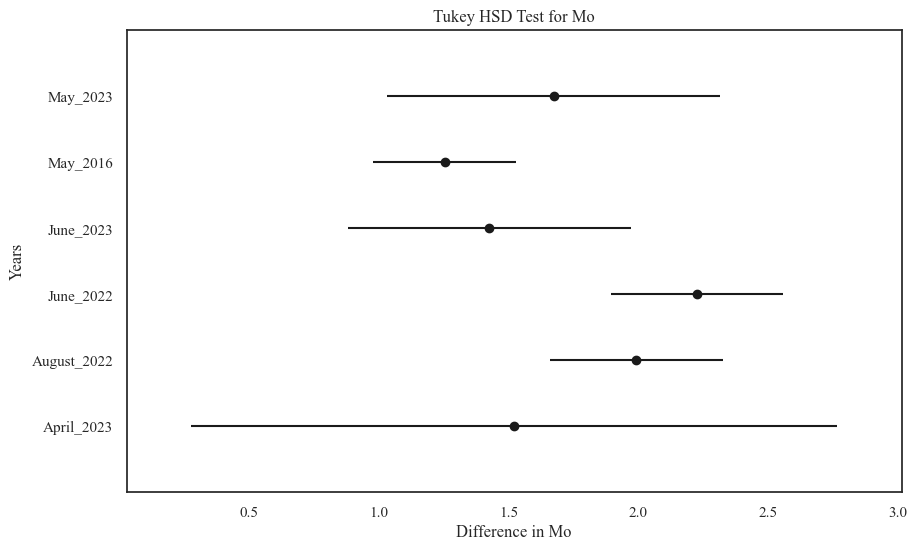

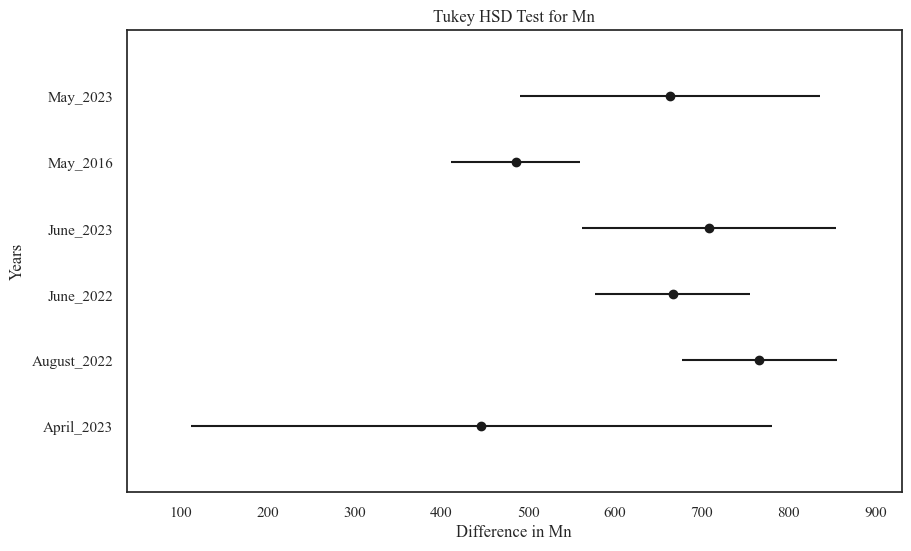

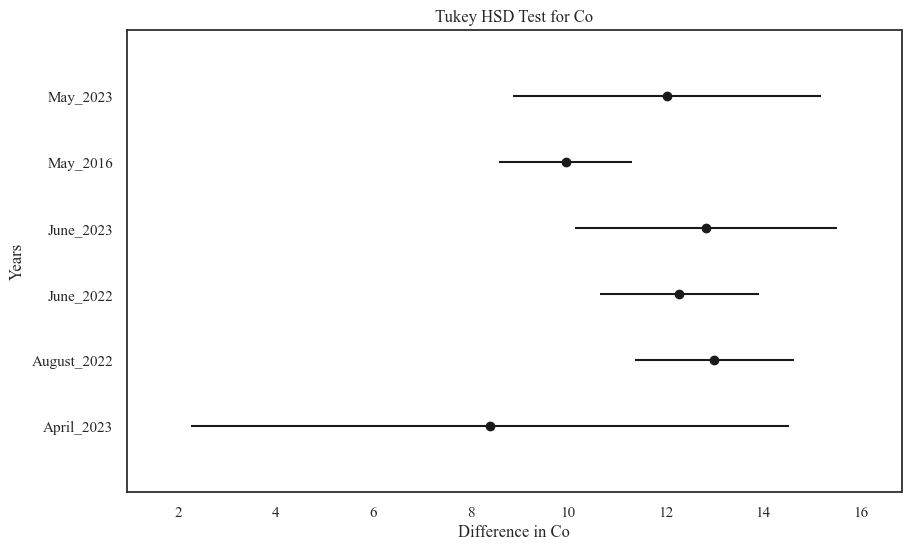

   Metal   F-value   p-value Hypothesis  df_between  df_within     N  \
0     Sr  0.671360  0.646997   Accepted         5.0       50.0  56.0   
1     Mo  6.803708  0.000066   Rejected         5.0       50.0  56.0   
2     Cd  1.009191  0.422173   Accepted         5.0       50.0  56.0   
3     Pb  1.506197  0.204741   Accepted         5.0       50.0  56.0   
4     Cr  0.856447  0.516838   Accepted         5.0       50.0  56.0   
5     Mn  7.835681  0.000017   Rejected         5.0       50.0  56.0   
6     Fe  0.875391  0.504398   Accepted         5.0       50.0  56.0   
7     Co  3.261477  0.012609   Rejected         5.0       50.0  56.0   
8     Ni  1.454590  0.221432   Accepted         5.0       50.0  56.0   
9     Cu  1.152387  0.345641   Accepted         5.0       50.0  56.0   
10    Zn  1.880142  0.114532   Accepted         5.0       50.0  56.0   

                                    Significant Pairs  
0                                                None  
1   April_2023 vs Augus

In [79]:
results_summary = []

for metal in metal_anova:
    result = anova_results[metal]

    # Extract ANOVA statistics
    f_value = result.loc['C(Year)', 'F']
    p_value = result.loc['C(Year)', 'PR(>F)']
    df_between = result.loc['C(Year)', 'df']
    df_within = result.loc['Residual', 'df']
    N = df_between + df_within + 1      # total observations used

    # Determine hypothesis result
    hypothesis_result = 'Rejected' if p_value < alpha else 'Accepted'

    # Placeholder for Tukey results
    significant_pairs = ""

    # Tukey HSD only if significant
    if hypothesis_result == 'Rejected':
        tukey_result = pairwise_tukeyhsd(m_data1[metal], m_data1['Year'], alpha=alpha)

        tukey_significant = tukey_result.summary().data[1:]
        for row in tukey_significant:
            if row[-1] < alpha:
                significant_pairs += f"{row[0]} vs {row[1]}, "
        significant_pairs = significant_pairs.rstrip(", ")

        tukey_result.plot_simultaneous()
        plt.title(f'Tukey HSD Test for {metal}')
        plt.xlabel(f'Difference in {metal}')
        plt.ylabel('Years')
        plt.show()

    # Add results to summary
    results_summary.append({
        'Metal': metal,
        'F-value': f_value,
        'p-value': p_value,
        'Hypothesis': hypothesis_result,
        'df_between': df_between,
        'df_within': df_within,
        'N': N,
        'Significant Pairs': significant_pairs if significant_pairs else 'None'
    })

summary_table = pd.DataFrame(results_summary)
print(summary_table)